In [1]:
from netCDF4 import Dataset 
import numpy as np 
np.bool = np.bool_
import math
import scipy.stats as stats 
import matplotlib.pyplot as plot
from scipy.optimize import curve_fit
from matplotlib.pyplot import MultipleLocator
from scipy import signal
import scipy.io
from scipy import signal
# import seaborn
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn import preprocessing
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis

#from cartopy.util import add_cyclic_point
#import cartopy.crs as ccrs

In [2]:
#filename1 = '/project2/tas1/ockham/data11/tas/echam-aiv_rcc_6.1.00p1/echr0028/ATM_dm_pl_echr0028_1031.nc'
filename1 = '/project2/tas1/ockham/data11/tas/echam-aiv_rcc_6.1.00p1/echr0028/ATM_6h_pl_echr0028_103001.nc'
ncin1 = Dataset(filename1, 'r', format='NETCDF4') 
lat = ncin1.variables['lat'] 
lat = (np.array(lat))
lon = ncin1.variables['lon'] 
lon = (np.array(lon))
plev = ncin1.variables['lev'] 
plev = (np.array(plev))
t = ncin1.variables['t'] 
t = (np.array(t))
t.shape #u[day,plev,lat,lon]
#print(lat)
print(plev[14]/100) # 50 hPa
print(plev[12]/100) # 100 hPa
print(plev[17]/100) # 10 hPa
print(plev[2]/100)
print(plev[8]/100)

50.0
100.0
10.0
850.0
300.0


In [3]:

simu = ['all','flat','syms','fs']

vbarn = np.zeros((4,31,26,192,5,60))
tbarn = np.zeros((4,31,26,192,5,60))

for s in range(4):
    print(s)
    
    for yy in range(30,90):
        #print(yy)
        filename2 = 'v.t.daily/'+simu[s]+'.'+str(yy)+'.nc'
        ncin1 = Dataset(filename2, 'r', format='NETCDF4') 
        v = ncin1.variables['v'] 
        v = (np.array(v))
        t = ncin1.variables['t'] 
        t = (np.array(t))
        
        vbarn[s,:,:,:,0:2,yy-30] = v[:,:,:,10:12]
        tbarn[s,:,:,:,0:2,yy-30] = t[:,:,:,10:12]
        if yy!=30:
            vbarn[s,:,:,:,2:5,yy-30-1] = v[:,:,:,0:3]
            tbarn[s,:,:,:,2:5,yy-30-1] = t[:,:,:,0:3]

0
1
2
3


In [4]:
vbarn_ed = np.zeros((4,31,26,192,5,60))
tbarn_ed = np.zeros((4,31,26,192,5,60))

for i in range(4):
    for d in range(31):
        for h in range(26):
            for m in range(5):
                for y in range(60):
                    vbarn_ed[i,d,h,:,m,y] = vbarn[i,d,h,:,m,y] - np.nanmean(vbarn[i,d,h,:,m,y])
                    tbarn_ed[i,d,h,:,m,y] = tbarn[i,d,h,:,m,y] - np.nanmean(tbarn[i,d,h,:,m,y])

/tmp/ipykernel_39900/352944355.py:9: RuntimeWarning: Mean of empty slice
  vbarn_ed[i,d,h,:,m,y] = vbarn[i,d,h,:,m,y] - np.nanmean(vbarn[i,d,h,:,m,y])
/tmp/ipykernel_39900/352944355.py:10: RuntimeWarning: Mean of empty slice
  tbarn_ed[i,d,h,:,m,y] = tbarn[i,d,h,:,m,y] - np.nanmean(tbarn[i,d,h,:,m,y])


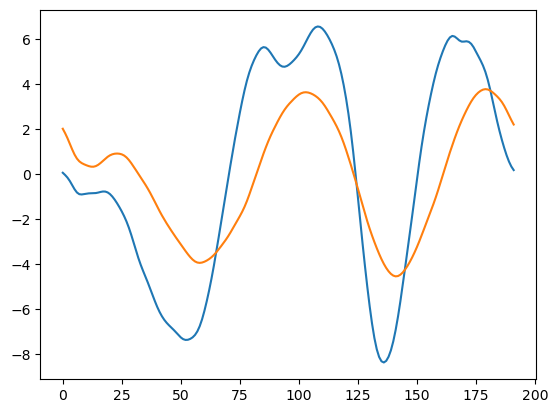

In [5]:
i = 0;d=0;h=8;m=2;y=52

plot.plot(np.nanmean(np.nanmean(np.nanmean(vbarn[i,:,h,:,:,:],axis=0),axis=1),axis=1))
plot.plot(np.nanmean(np.nanmean(np.nanmean(vbarn[1,:,h,:,:,:],axis=0),axis=1),axis=1))
          
#plot.plot(np.nanmean(vbarn[1,:,h,:,:,:],axis=0))
# plot.plot(np.nanmean(vbarn[2,:,h,:,m,y],axis=0))
# plot.plot(np.nanmean(vbarn[3,:,h,:,m,y],axis=0))
#plot.plot(tbarn[i,:,h,0,m,y]-np.mean(tbarn[i,:,h,:,m,y],axis=1))

#sns.kdeplot(np.reshape(vbarn[0,:,h,:,m,y],31*192))
#sns.kdeplot(np.reshape(vbarn[1,:,h,:,m,y],31*192))
#sns.kdeplot(vbarn[1,:,h,:,m,y])
#sns.kdeplot(np.nanmean(vbarn[0,:,h,:,m,y],axis=0))
#sns.kdeplot(np.nanmean(vbarn[1,:,h,:,m,y],axis=0))

# NH

In [6]:
wmin = 0#8000
wmax = 5 #wavenumber
#rmax = 10#forcing years
#allfr = np.zeros((4,360*rmax),dtype = 'complex_')
v_all = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
t_all = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
v_phase = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
t_phase = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
f = np.zeros(wmax)

#epz[epz<0]=0 ######################################## do we want this????



for h in range(26):
    print(h)
    for m in range(5):
        for y in range(60):
            for i in range(4):
                signal = np.nanmean(vbarn_ed[i,:,h,:,m,y],axis=0)
                #print(signal)
                lon = np.arange(0,192,1)
                period = len(lon)
                for n in range(wmin,wmax):
                    #print(n)         
                    c = signal*np.exp(-1j*2*n*(np.pi*lon/period))
                    #print(c)
                    cn = c.sum()/c.size
                    #print(cn)
                    v_all[i,n,h,m,y] = cn
                    v_phase[i,n,h,m,y] = np.angle(cn)
                

for h in range(26):
    print(h)
    for m in range(5):
        for y in range(60):
            for i in range(4):
                signal = np.nanmean(tbarn_ed[i,:,h,:,m,y],axis=0)
                lon = np.arange(0,192,1)
                period = len(lon)
                for n in range(wmin,wmax):
                    #print(n)         
                    c = signal*np.exp(-1j*2*n*(np.pi*lon/period))
                    cn = c.sum()/c.size
                    t_all[i,n,h,m,y] = cn
                    t_phase[i,n,h,m,y] = np.angle(cn)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [7]:
print(np.nanmean(abs(v_all[0,2,12,:,:])))
print(np.nanmean(abs(v_all[1,2,12,:,:])))
print(np.nanmean(abs(v_all[2,2,12,:,:])))
print(np.nanmean(abs(v_all[3,2,12,:,:])))


3.018854345851835
2.930072551637609
3.004363827907523
3.190547939436842


/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

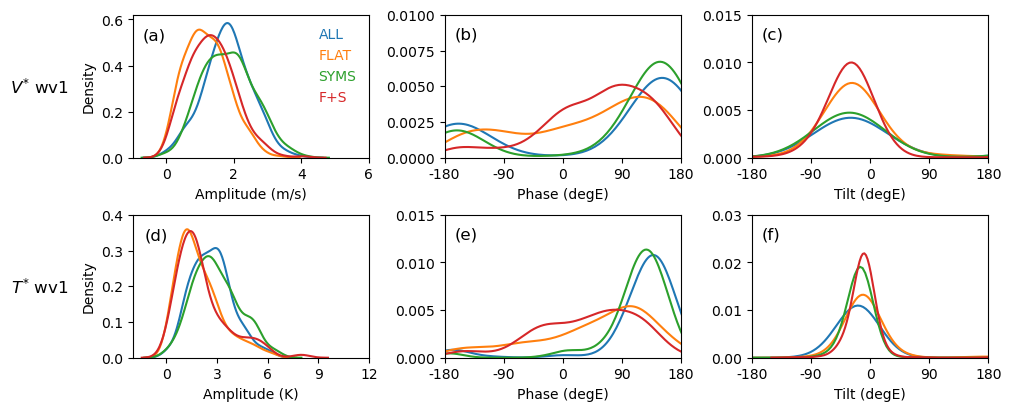

In [8]:
fig,ax = plot.subplots(2,3,figsize=(10,4),constrained_layout=True)
plot.rcParams['font.size'] = '12'

labels = ['ALL','FLAT','SYMS','F+S']
pad =5

rows =  ['${V^{*}}$ wv1', '${T^{*}}$ wv1']
for axx, row in zip(ax[:,0], rows):
    axx.annotate(row, xy=(0, 0.5), xytext=(-axx.yaxis.labelpad - pad, 0),
                xycoords=axx.yaxis.label, textcoords='offset points',
                size='12', ha='right', va='center')


for s in range(4):
    sns.kdeplot(np.reshape(abs(v_all[s,1,12,:,:]),5*60),ax=ax[0,0],label=labels[s])
    ax[0,0].set_xlim([-1,6])
    ax[0,0].set_ylim([0,0.62])

    
    sns.kdeplot(np.reshape(abs(t_all[s,1,12,:,:]),5*60),ax=ax[1,0],label=labels[s])
    ax[1,0].set_xlim([-2,12])
    ax[1,0].set_ylim([0,0.4])
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,1,12,:,:])*180/np.pi,5*60),ax=ax[0,1])
    ax[0,1].set_xlim([-180,180])
    ax[0,1].set_ylim([0,0.01])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,1,12,:,:])*180/np.pi,5*60),ax=ax[1,1])
    ax[1,1].set_xlim([-180,180])
    ax[1,1].set_ylim([0,0.015])

    sns.kdeplot(np.reshape(np.real(v_phase[s,1,11,:,:]-v_phase[s,1,13,:,:])*180/np.pi,5*60),ax=ax[0,2],label=labels[s])
    ax[0,2].set_xlim([-180,180])
    ax[0,2].set_ylim([0,0.015])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,1,11,:,:]-t_phase[s,1,13,:,:])*180/np.pi,5*60),ax=ax[1,2],label=labels[s])
    ax[1,2].set_xlim([-180,180])
    ax[1,2].set_ylim([0,0.03])

    
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
leg =  ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)
for color,text in zip(colors,leg.get_texts()):
    text.set_color(color)
    
for l in leg.legendHandles:
    l.set_linewidth(0)
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis

ax[0,0].text(-0.7,0.51,'(a)')
ax[0,1].text(-165,0.0083,'(b)')
ax[0,2].text(-165,0.0125,'(c)')

ax[1,0].text(-1.3,0.33,'(d)')
ax[1,1].text(-165,0.0125,'(e)')
ax[1,2].text(-165,0.025,'(f)')

ax[0,0].set_xticks([0,2,4,6])
ax[0,0].set_xticklabels([0,2,4,6]) 
ax[0,0].set_xlabel('Amplitude (m/s)')
ax[1,0].set_xticks([0,3,6,9,12])
ax[1,0].set_xticklabels([0,3,6,9,12]) 
ax[1,0].set_xlabel('Amplitude (K)')

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_xlabel('Phase (degE)')
ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_xlabel('Phase (degE)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_xlabel('Tilt (degE)')
ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_xlabel('Tilt (degE)')
ax[0,2].set_ylabel('') 
ax[1,2].set_ylabel('') 

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vn_new.pdf',dpi=600,bbox_inches='tight') 

In [9]:
import statistics

from scipy.stats import gaussian_kde

# print(statistics.mode(np.reshape(abs(v_all[0,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(v_all[1,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(v_all[2,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(v_all[3,2,12,:,:]),5*60)))
# print("    ")

# print(statistics.mode(np.reshape(abs(t_all[0,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(t_all[1,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(t_all[2,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(t_all[3,2,12,:,:]),5*60)))




data = np.reshape(abs(v_all[0,2,12,:,:]),5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(abs(v_all[1,2,12,:,:]),5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(abs(v_all[2,2,12,:,:]),5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(abs(v_all[3,2,12,:,:]),5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)



print("    ")


data = np.reshape(abs(t_all[0,2,12,:,:]),5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(abs(t_all[1,2,12,:,:]),5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(abs(t_all[2,2,12,:,:]),5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(abs(t_all[3,2,12,:,:]),5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)


3.194855107621841
2.313947052061337
2.5472753193795126
1.9684386541753882
    
0.7600664809809573
0.4123143328474976
0.5803823825280497
0.44555484881566304


In [10]:
import statistics

from scipy.stats import gaussian_kde

# print(statistics.mode(np.reshape(abs(v_all[0,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(v_all[1,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(v_all[2,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(v_all[3,2,12,:,:]),5*60)))
# print("    ")

# print(statistics.mode(np.reshape(abs(t_all[0,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(t_all[1,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(t_all[2,2,12,:,:]),5*60)))
# print(statistics.mode(np.reshape(abs(t_all[3,2,12,:,:]),5*60)))


data = np.reshape(np.real(v_phase[0,2,12,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(np.real(v_phase[1,2,12,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(np.real(v_phase[2,2,12,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(np.real(v_phase[3,2,12,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)



print("    ")


data = np.reshape(np.real(t_phase[0,2,12,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(np.real(t_phase[1,2,12,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(np.real(t_phase[2,2,12,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)

data = np.reshape(np.real(t_phase[3,2,12,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde(x_values)
index_of_max_pdf = np.argmax(pdf_values)
x_at_max_pdf = x_values[index_of_max_pdf]
print(x_at_max_pdf)


34.04244264081953
0.5613643826169437
15.015477547614765
19.517217949655503
    
4.197371628041424
-63.25308054806571
-7.921269204835966
-42.290306331553836


In [11]:
import statistics

print((statistics.median(np.reshape(np.real(v_phase[0,2,12,:,:])*180/np.pi,5*60))-statistics.median(np.reshape(np.real(v_phase[1,2,12,:,:])*180/np.pi,5*60)))/statistics.median(np.reshape(np.real(v_phase[0,2,12,:,:])*180/np.pi,5*60)))
#print(statistics.median(np.reshape(np.real(v_phase[1,1,12,:,:])*180/np.pi,5*60)))
print((statistics.median(np.reshape(np.real(v_phase[2,2,12,:,:])*180/np.pi,5*60))-statistics.median(np.reshape(np.real(v_phase[3,2,12,:,:])*180/np.pi,5*60)))/statistics.median(np.reshape(np.real(v_phase[2,2,12,:,:])*180/np.pi,5*60)))
#print(statistics.median(np.reshape(np.real(v_phase[3,1,12,:,:])*180/np.pi,5*60)))
print("    ")

print((statistics.median(np.reshape(np.real(t_phase[0,2,12,:,:])*180/np.pi,5*60))-statistics.median(np.reshape(np.real(t_phase[1,2,12,:,:])*180/np.pi,5*60)))/statistics.median(np.reshape(np.real(t_phase[0,2,12,:,:])*180/np.pi,5*60)))
#print(statistics.median(np.reshape(np.real(t_phase[1,1,12,:,:])*180/np.pi,5*60)))
print((statistics.median(np.reshape(np.real(t_phase[2,2,12,:,:])*180/np.pi,5*60))-statistics.median(np.reshape(np.real(t_phase[3,2,12,:,:])*180/np.pi,5*60)))/statistics.median(np.reshape(np.real(t_phase[2,2,12,:,:])*180/np.pi,5*60)))
#print(statistics.median(np.reshape(np.real(t_phase[3,1,12,:,:])*180/np.pi,5*60)))

0.8434275753130019
-0.21396682796279426
    
4.982110239896714
-1.6031999735059506


In [12]:
from scipy.stats import kurtosis

data = np.reshape(np.real(t_phase[0,1,11,:,:]-t_phase[0,1,13,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
pdf_values = kde(x_values)
max_pdf = np.max(pdf_values)
print(max_pdf)

data = np.reshape(np.real(t_phase[1,1,11,:,:]-t_phase[1,1,13,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
pdf_values = kde(x_values)
max_pdf = np.max(pdf_values)
print(max_pdf)

data = np.reshape(np.real(t_phase[2,1,11,:,:]-t_phase[2,1,13,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
pdf_values = kde(x_values)
max_pdf = np.max(pdf_values)
print(max_pdf)

data = np.reshape(np.real(t_phase[3,1,11,:,:]-t_phase[3,1,13,:,:])*180/np.pi,5*60)
kde = gaussian_kde(data)
pdf_values = kde(x_values)
max_pdf = np.max(pdf_values)
print(max_pdf)

0.01095367939716117
0.013229722844093347
0.019100005650850172
0.021931830532253678


/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/smliu01/scratch-midway2/environment/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

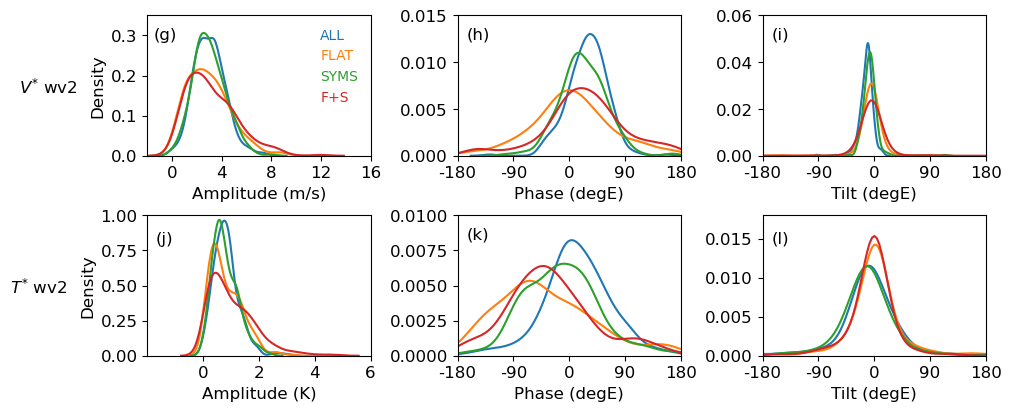

In [8]:
fig,ax = plot.subplots(2,3,figsize=(10,4),constrained_layout=True)
plot.rcParams['font.size'] = '12'

labels = ['ALL','FLAT','SYMS','F+S']

pad =5

rows =  ['${V^{*}}$ wv2', '${T^{*}}$ wv2']
for axx, row in zip(ax[:,0], rows):
    axx.annotate(row, xy=(0, 0.5), xytext=(-axx.yaxis.labelpad - pad, 0),
                xycoords=axx.yaxis.label, textcoords='offset points',
                size='12', ha='right', va='center')



for s in range(4):
    sns.kdeplot(np.reshape(abs(v_all[s,2,12,:,:]),5*60),ax=ax[0,0],label=labels[s])
    ax[0,0].set_xlim([-2,16])
    ax[0,0].set_ylim([0,0.35])
    
    sns.kdeplot(np.reshape(abs(t_all[s,2,12,:,:]),5*60),ax=ax[1,0],label=labels[s])
    ax[1,0].set_xlim([-2,6])
    ax[1,0].set_ylim([0,1])
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,2,12,:,:])*180/np.pi,5*60),ax=ax[0,1])
    ax[0,1].set_xlim([-180,180])
    ax[0,1].set_ylim([0,0.015])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,2,12,:,:])*180/np.pi,5*60),ax=ax[1,1])
    ax[1,1].set_xlim([-180,180])
    ax[1,1].set_ylim([0,0.01])

    sns.kdeplot(np.reshape(np.real(v_phase[s,2,11,:,:]-v_phase[s,2,13,:,:])*180/np.pi,5*60),ax=ax[0,2],label=labels[s])
    ax[0,2].set_xlim([-180,180])
    ax[0,2].set_ylim([0,0.06])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,2,11,:,:]-t_phase[s,2,13,:,:])*180/np.pi,5*60),ax=ax[1,2],label=labels[s])
    ax[1,2].set_xlim([-180,180])
    ax[1,2].set_ylim([0,0.018])
    
    #ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
leg =  ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)
for color,text in zip(colors,leg.get_texts()):
    text.set_color(color)
    
for l in leg.legendHandles:
    l.set_linewidth(0)    
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis

ax[0,0].text(-1.5,0.29,'(g)')
ax[0,1].text(-165,0.0125,'(h)')
ax[0,2].text(-165,0.05,'(i)')

ax[1,0].text(-1.7,0.8,'(j)')
ax[1,1].text(-165,0.0083,'(k)')
ax[1,2].text(-165,0.0145,'(l)')

ax[0,0].set_xticks([0,4,8,12,16])
ax[0,0].set_xticklabels([0,4,8,12,16]) 
ax[0,0].set_xlabel('Amplitude (m/s)')
ax[1,0].set_xticks([0,2,4,6])
ax[1,0].set_xticklabels([0,2,4,6]) 
ax[1,0].set_xlabel('Amplitude (K)')

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_xlabel('Phase (degE)')
ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_xlabel('Phase (degE)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_xlabel('Tilt (degE)')
ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_xlabel('Tilt (degE)')
ax[0,2].set_ylabel('') 
ax[1,2].set_ylabel('') 

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vn_new_w2.png',dpi=600,bbox_inches='tight') 

/tmp/ipykernel_39900/3461989185.py:88: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in leg.legendHandles:


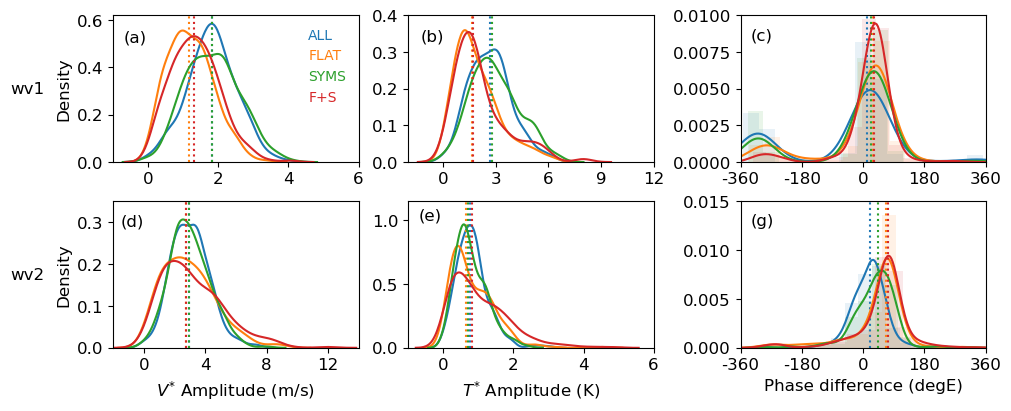

In [8]:
import warnings


# Filter out the specific FutureWarnings globally
warnings.filterwarnings("ignore", category=FutureWarning)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig,ax = plot.subplots(2,3,figsize=(10,4),constrained_layout=True)
plot.rcParams['font.size'] = '12'

labels = ['ALL','FLAT','SYMS','F+S']
pad =5

rows =  ['wv1', 'wv2']
for axx, row in zip(ax[:,0], rows):
    axx.annotate(row, xy=(0, 0.5), xytext=(-axx.yaxis.labelpad - pad, 0),
                xycoords=axx.yaxis.label, textcoords='offset points',
                size='12', ha='right', va='center')

pc = 50

for s in range(4):
    sns.kdeplot(np.reshape(abs(v_all[s,1,12,:,:]),5*60),ax=ax[0,0],label=labels[s])
    ax[0,0].set_xlim([-1,6])
    ax[0,0].set_ylim([0,0.62])
    median_value = np.percentile(np.reshape(abs(v_all[s,1,12,:,:]),5*60),pc)
    ax[0,0].axvline(median_value, linestyle=':',color=colors[s])

    
    sns.kdeplot(np.reshape(abs(t_all[s,1,12,:,:]),5*60),ax=ax[0,1],label=labels[s])
    ax[0,1].set_xlim([-2,12])
    ax[0,1].set_ylim([0,0.4])
    median_value = np.percentile(np.reshape(abs(t_all[s,1,12,:,:]),5*60),pc)
    ax[0,1].axvline(median_value, linestyle=':',color=colors[s])
    
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,1,12,:,:])*180/np.pi-np.real(t_phase[s,1,12,:,:])*180/np.pi,5*60),ax=ax[0,2],color=colors[s])
    ax[0,2].hist(np.reshape(np.real(v_phase[s,1,12,:,:])*180/np.pi-np.real(t_phase[s,1,12,:,:])*180/np.pi,5*60),color=colors[s], bins=15, density=True,alpha = 0.1)
    ax[0,2].set_xlim([-360,360])
    ax[0,2].set_ylim([0,0.01])
    median_value = np.percentile(np.reshape(np.real(v_phase[s,1,12,:,:])*180/np.pi-np.real(t_phase[s,1,12,:,:])*180/np.pi,5*60),pc)
    ax[0,2].axvline(median_value, linestyle=':',color=colors[s])
        
    
    sns.kdeplot(np.reshape(abs(v_all[s,2,12,:,:]),5*60),ax=ax[1,0],label=labels[s])
    ax[1,0].set_xlim([-2,14])
    ax[1,0].set_ylim([0,0.35])
    median_value = np.percentile(np.reshape(abs(v_all[s,2,12,:,:]),5*60),pc)
    ax[1,0].axvline(median_value, linestyle=':',color=colors[s])

    
    
    sns.kdeplot(np.reshape(abs(t_all[s,2,12,:,:]),5*60),ax=ax[1,1],label=labels[s])
    ax[1,1].set_xlim([-1,6])
    ax[1,1].set_ylim([0,1.15])
    median_value = np.percentile(np.reshape(abs(t_all[s,2,12,:,:]),5*60),pc)
    ax[1,1].axvline(median_value, linestyle=':',color=colors[s])

    
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,2,12,:,:])*180/np.pi-np.real(t_phase[s,2,12,:,:])*180/np.pi,5*60),ax=ax[1,2],color=colors[s])
    ax[1,2].hist(np.reshape(np.real(v_phase[s,2,12,:,:])*180/np.pi-np.real(t_phase[s,2,12,:,:])*180/np.pi,5*60),color=colors[s], bins=15, density=True,alpha = 0.1)
    ax[1,2].set_xlim([-360,360])
    ax[1,2].set_ylim([0,0.015])
    median_value = np.percentile(np.reshape(np.real(v_phase[s,2,12,:,:])*180/np.pi-np.real(t_phase[s,2,12,:,:])*180/np.pi,5*60),pc)
    ax[1,2].axvline(median_value, linestyle=':',color=colors[s])
    
#     sns.kdeplot(np.reshape(np.real(t_phase[s,1,12,:,:])*180/np.pi,5*60),ax=ax[1,1])
#     ax[1,1].set_xlim([-180,180])
#     ax[1,1].set_ylim([0,0.015])

#     sns.kdeplot(np.reshape(np.real(v_phase[s,1,11,:,:]-v_phase[s,1,13,:,:])*180/np.pi,5*60),ax=ax[0,2],label=labels[s])
#     ax[0,2].set_xlim([-180,180])
#     ax[0,2].set_ylim([0,0.015])
    
#     sns.kdeplot(np.reshape(np.real(t_phase[s,1,11,:,:]-t_phase[s,1,13,:,:])*180/np.pi,5*60),ax=ax[1,2],label=labels[s])
#     ax[1,2].set_xlim([-180,180])
#     ax[1,2].set_ylim([0,0.03])

    
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
leg =  ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)
for color,text in zip(colors,leg.get_texts()):
    text.set_color(color)
    
for l in leg.legendHandles:
    l.set_linewidth(0)
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-360,-180,0,180,360]
xxx = [-360,-180,0,180,360]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis

ax[0,0].text(-0.7,0.51,'(a)')
ax[0,1].text(-1.3,0.33,'(b)')
ax[0,2].text(-330,0.0083,'(c)')

ax[1,0].text(-1.5,0.29,'(d)')
ax[1,1].text(-0.7,1,'(e)')
ax[1,2].text(-330,0.0125,'(g)')

ax[0,0].set_xticks([0,2,4,6])
ax[0,0].set_xticklabels([0,2,4,6]) 
#ax[0,0].set_xlabel('${V^{*}}$ Amplitude (m/s)')
ax[0,1].set_xticks([0,3,6,9,12])
ax[0,1].set_xticklabels([0,3,6,9,12]) 
#ax[0,1].set_xlabel('${T^{*}}$ Amplitude (K)')

ax[1,0].set_xticks([0,4,8,12])
ax[1,0].set_xticklabels([0,4,8,12])
ax[1,0].set_xlabel('${V^{*}}$ Amplitude (m/s)')
ax[1,1].set_xticks([0,2,4,6])
ax[1,1].set_xticklabels([0,2,4,6])
ax[1,1].set_xlabel('${T^{*}}$ Amplitude (K)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
#ax[0,2].set_xlabel('Phase difference (degE)')
ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_xlabel('Phase difference (degE)')
ax[0,2].set_ylabel('') 
ax[1,2].set_ylabel('') 

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vn_new_p.pdf',dpi=600,bbox_inches='tight') 

/tmp/ipykernel_39900/2516802563.py:88: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in leg.legendHandles:


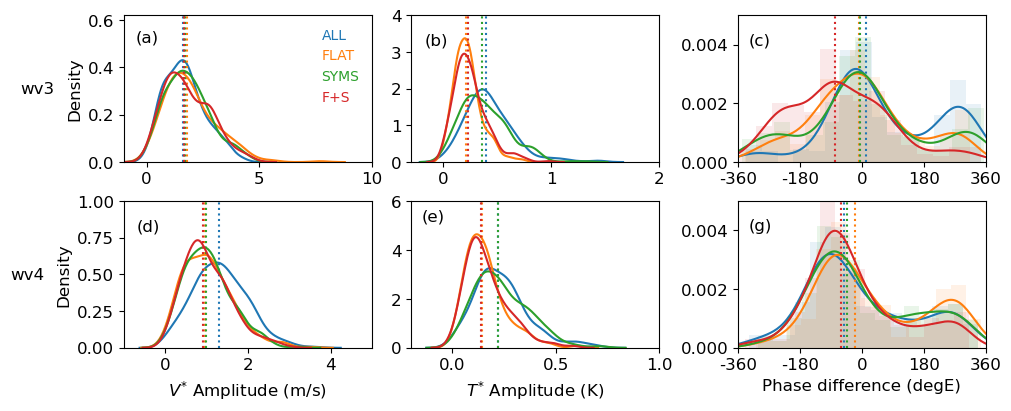

In [9]:
import warnings


# Filter out the specific FutureWarnings globally
warnings.filterwarnings("ignore", category=FutureWarning)



fig,ax = plot.subplots(2,3,figsize=(10,4),constrained_layout=True)
plot.rcParams['font.size'] = '12'

labels = ['ALL','FLAT','SYMS','F+S']
pad =5

rows =  ['wv3', 'wv4']
for axx, row in zip(ax[:,0], rows):
    axx.annotate(row, xy=(0, 0.5), xytext=(-axx.yaxis.labelpad - pad, 0),
                xycoords=axx.yaxis.label, textcoords='offset points',
                size='12', ha='right', va='center')

pc = 50

for s in range(4):
    sns.kdeplot(np.reshape(abs(v_all[s,3,12,:,:]),5*60),ax=ax[0,0],label=labels[s])
    ax[0,0].set_xlim([-1,10])
    ax[0,0].set_ylim([0,0.62])
    median_value = np.percentile(np.reshape(abs(v_all[s,3,12,:,:]),5*60),pc)
    ax[0,0].axvline(median_value, linestyle=':',color=colors[s])

    
    sns.kdeplot(np.reshape(abs(t_all[s,3,12,:,:]),5*60),ax=ax[0,1],label=labels[s])
    ax[0,1].set_xlim([-0.3,2])
    ax[0,1].set_ylim([0,4])
    median_value = np.percentile(np.reshape(abs(t_all[s,3,12,:,:]),5*60),pc)
    ax[0,1].axvline(median_value, linestyle=':',color=colors[s])
    
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,3,12,:,:])*180/np.pi-np.real(t_phase[s,3,12,:,:])*180/np.pi,5*60),ax=ax[0,2],color=colors[s])
    ax[0,2].hist(np.reshape(np.real(v_phase[s,3,12,:,:])*180/np.pi-np.real(t_phase[s,3,12,:,:])*180/np.pi,5*60),color=colors[s], bins=15, density=True,alpha = 0.1)
    ax[0,2].set_xlim([-360,360])
    ax[0,2].set_ylim([0,0.005])
    median_value = np.percentile(np.reshape(np.real(v_phase[s,3,12,:,:])*180/np.pi-np.real(t_phase[s,3,12,:,:])*180/np.pi,5*60),pc)
    ax[0,2].axvline(median_value, linestyle=':',color=colors[s])
        
    
    sns.kdeplot(np.reshape(abs(v_all[s,4,12,:,:]),5*60),ax=ax[1,0],label=labels[s])
    ax[1,0].set_xlim([-1,5])
    ax[1,0].set_ylim([0,1])
    median_value = np.percentile(np.reshape(abs(v_all[s,4,12,:,:]),5*60),pc)
    ax[1,0].axvline(median_value, linestyle=':',color=colors[s])

    
    
    sns.kdeplot(np.reshape(abs(t_all[s,4,12,:,:]),5*60),ax=ax[1,1],label=labels[s])
    ax[1,1].set_xlim([-0.2,1])
    ax[1,1].set_ylim([0,6])
    median_value = np.percentile(np.reshape(abs(t_all[s,4,12,:,:]),5*60),pc)
    ax[1,1].axvline(median_value, linestyle=':',color=colors[s])

    
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,4,12,:,:])*180/np.pi-np.real(t_phase[s,4,12,:,:])*180/np.pi,5*60),ax=ax[1,2],color=colors[s])
    ax[1,2].hist(np.reshape(np.real(v_phase[s,4,12,:,:])*180/np.pi-np.real(t_phase[s,4,12,:,:])*180/np.pi,5*60),color=colors[s], bins=15, density=True,alpha = 0.1)
    ax[1,2].set_xlim([-360,360])
    ax[1,2].set_ylim([0,0.005])
    median_value = np.percentile(np.reshape(np.real(v_phase[s,4,12,:,:])*180/np.pi-np.real(t_phase[s,4,12,:,:])*180/np.pi,5*60),pc)
    ax[1,2].axvline(median_value, linestyle=':',color=colors[s])
    
#     sns.kdeplot(np.reshape(np.real(t_phase[s,1,12,:,:])*180/np.pi,5*60),ax=ax[1,1])
#     ax[1,1].set_xlim([-180,180])
#     ax[1,1].set_ylim([0,0.015])

#     sns.kdeplot(np.reshape(np.real(v_phase[s,1,11,:,:]-v_phase[s,1,13,:,:])*180/np.pi,5*60),ax=ax[0,2],label=labels[s])
#     ax[0,2].set_xlim([-180,180])
#     ax[0,2].set_ylim([0,0.015])
    
#     sns.kdeplot(np.reshape(np.real(t_phase[s,1,11,:,:]-t_phase[s,1,13,:,:])*180/np.pi,5*60),ax=ax[1,2],label=labels[s])
#     ax[1,2].set_xlim([-180,180])
#     ax[1,2].set_ylim([0,0.03])

    
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
leg =  ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)
for color,text in zip(colors,leg.get_texts()):
    text.set_color(color)
    
for l in leg.legendHandles:
    l.set_linewidth(0)
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])
xx = [-360,-180,0,180,360]
xxx = [-360,-180,0,180,360]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis

ax[0,0].text(-0.5,0.51,'(a)')
ax[0,1].text(-0.17,3.2,'(b)')
ax[0,2].text(-330,0.004,'(c)')

ax[1,0].text(-0.7,0.8,'(d)')
ax[1,1].text(-0.15,5.2,'(e)')
ax[1,2].text(-330,0.004,'(g)')

#ax[0,0].set_xticks([0,2,4,6])
#ax[0,0].set_xticklabels([0,2,4,6]) 
#ax[0,0].set_xlabel('${V^{*}}$ Amplitude (m/s)')
#ax[0,1].set_xticks([0,3,6,9,12])
#ax[0,1].set_xticklabels([0,3,6,9,12]) 
#ax[0,1].set_xlabel('${T^{*}}$ Amplitude (K)')

#ax[1,0].set_xticks([0,4,8,12])
#ax[1,0].set_xticklabels([0,4,8,12])
ax[1,0].set_xlabel('${V^{*}}$ Amplitude (m/s)')
#ax[1,1].set_xticks([0,2,4,6])
#ax[1,1].set_xticklabels([0,2,4,6])
ax[1,1].set_xlabel('${T^{*}}$ Amplitude (K)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
#ax[0,2].set_xlabel('Phase difference (degE)')
ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_xlabel('Phase difference (degE)')
ax[0,2].set_ylabel('') 
ax[1,2].set_ylabel('') 

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vn_new_34_p.pdf',dpi=600,bbox_inches='tight') 

In [16]:
np.corrcoef(x=np.reshape(np.real(v_phase[3,1,12,:,:])*180/np.pi,5*60),
                y=np.reshape(np.real(t_phase[3,1,12,:,:])*180/np.pi,5*60))[0,1]

0.4469380410594893

<Axes: >

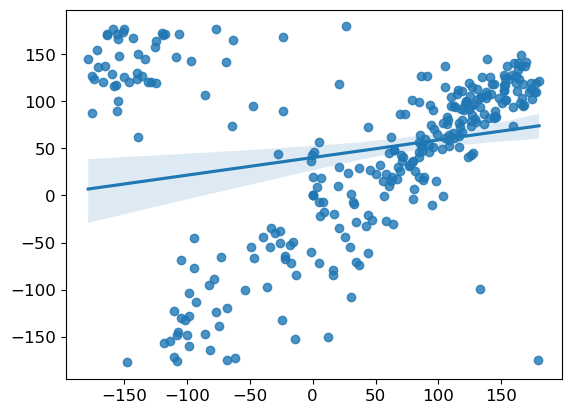

In [17]:
sns.regplot(x=np.reshape(np.real(v_phase[1,1,12,:,:])*180/np.pi,5*60),
                y=np.reshape(np.real(t_phase[1,1,12,:,:])*180/np.pi,5*60))

NameError: name 'dis_4' is not defined

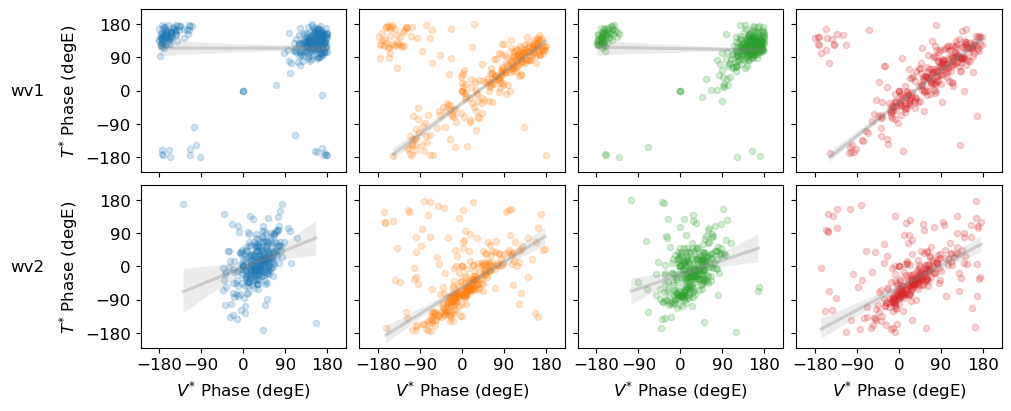

In [18]:
fig,ax = plot.subplots(2,4,figsize=(10,4),constrained_layout=True)


pad =5

rows =  ['wv1', 'wv2']
for axx, row in zip(ax[:,0], rows):
    axx.annotate(row, xy=(0, 0.5), xytext=(-axx.yaxis.labelpad - pad, 0),
                xycoords=axx.yaxis.label, textcoords='offset points',
                size='12', ha='right', va='center')



simu = ['ALL','FLAT','SYMS','F+S']
label = [['(a)','(b)','(c)','(d)'],['(e)','(f)',"(g)","(h)"]]

for i in range(2):
    ax[i,0].set_yticks([-180,-90,0,90,180])
    ax[i,0].set_ylabel('${T^{*}}$ Phase (degE)')

for i in range(4):
    ax[1,i].set_xticks([-180,-90,0,90,180])
    ax[1,i].set_xlabel('${V^{*}}$ Phase (degE)')

for i in range(4):
    ax[0,i].set_xticks([-180,-90,0,90,180])
    ax[0,i].set_xticklabels([])

for i in range(2):
    for j in range(1,4):
        ax[i,j].set_yticks([-180,-90,0,90,180])
        ax[i,j].set_yticklabels([])
        
for i in range(2):
    for j in range(4):
        ax[i,j].set_xlim(-220,220)
        ax[i,j].set_ylim(-220,220)
        
v_all_ft = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
t_all_ft = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
v_phase_ft = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
t_phase_ft = np.zeros((4,wmax,26,5,60),dtype = 'complex_')  

v_all_ft = v_all.copy()
t_all_ft = t_all.copy()
v_phase_ft = v_phase.copy()
t_phase_ft = t_phase.copy()
        
for i in range(5):
    for j in range(60):
        if v_phase[1,1,12,i,j]<0 and t_phase[1,1,12,i,j]>0:
            v_phase_ft[1,1,12,i,j]=np.nan
            t_phase_ft[1,1,12,i,j]=np.nan
        if v_phase[3,1,12,i,j]<0 and t_phase[3,1,12,i,j]>0:
            v_phase_ft[3,1,12,i,j]=np.nan
            t_phase_ft[3,1,12,i,j]=np.nan
        if v_phase[1,2,12,i,j]<0 and t_phase[1,2,12,i,j]>0:
            v_phase_ft[1,2,12,i,j]=np.nan
            t_phase_ft[1,2,12,i,j]=np.nan
        if v_phase[3,2,12,i,j]<0 and t_phase[3,2,12,i,j]>0:
            v_phase_ft[3,2,12,i,j]=np.nan
            t_phase_ft[3,2,12,i,j]=np.nan
            
for i in range(4):
    sns.regplot(x=np.reshape(np.real(v_phase[i,1,12,:,:])*180/np.pi,5*60),
                    y=np.reshape(np.real(t_phase[i,1,12,:,:])*180/np.pi,5*60),ax=ax[0,i],
                    scatter_kws={'s': 20,'alpha':0.2},color=colors[i],
                     line_kws=dict(color="gray",alpha=0.3),fit_reg=False)
        
            
for i in range(4):
    sns.regplot(x=np.reshape(np.real(v_phase_ft[i,1,12,:,:])*180/np.pi,5*60),
                    y=np.reshape(np.real(t_phase_ft[i,1,12,:,:])*180/np.pi,5*60),ax=ax[0,i],
                    scatter_kws={'s': 20,'alpha':0},color=colors[i],
                     line_kws=dict(color="gray",alpha=0.3),fit_reg=True,scatter=False)
        
for i in range(4):
    sns.regplot(x=np.reshape(np.real(v_phase[i,2,12,:,:])*180/np.pi,5*60),
                    y=np.reshape(np.real(t_phase[i,2,12,:,:])*180/np.pi,5*60),ax=ax[1,i],
                    scatter_kws={'s': 20,'alpha':0.2},color=colors[i],
                     line_kws=dict(color="gray",alpha=0.3),fit_reg=False)
        
            
for i in range(4):
    sns.regplot(x=np.reshape(np.real(v_phase_ft[i,2,12,:,:])*180/np.pi,5*60),
                    y=np.reshape(np.real(t_phase_ft[i,2,12,:,:])*180/np.pi,5*60),ax=ax[1,i],
                    scatter_kws={'s': 20,'alpha':0},color=colors[i],
                     line_kws=dict(color="gray",alpha=0.3),fit_reg=True,scatter=False)
        



# for i in range(4):
#     sns.regplot(x=np.reshape(np.real(v_phase[i,2,12,:,:])*180/np.pi,5*60),
#                     y=np.reshape(np.real(t_phase[i,2,12,:,:])*180/np.pi,5*60),ax=ax[1,i],
#                     scatter_kws={'s': 20,'alpha':0.2},color=colors[i],
#                      line_kws=dict(color="gray",alpha=0.3))
    
    
from scipy.stats import linregress

px = np.arange(-180,180,1)
py1 = np.arange(-180,180,1)
py2 = np.arange(180,-180,-1)


for i in range(2):
    for j in range(4):
        x = np.reshape(np.real(v_phase_ft[j,i+1,12,:,:])*180/np.pi,5*60)
        y = np.reshape(np.real(t_phase_ft[j,i+1,12,:,:])*180/np.pi,5*60)
        valid_indices = ~np.isnan(x) & ~np.isnan(y)
        x_valid = x[valid_indices]
        y_valid = y[valid_indices]
        slope, intercept, r_value, p_value, std_err = linregress(x_valid,y_valid)
#        ax[i,j].text(-200,-190,label[i][j]+' '+simu[j]+': '+ str(round(slope,3)))
        ax[i,j].text(-200,-190,label[i][j]+' '+simu[j]+': '+ str(round(np.mean(dis_4[j,i,:]),1)))
        #ax[i,j].text(-200,-190,label[i][j]+' '+simu[j]+': '+  \
        #             str(round(np.corrcoef(x=np.reshape(np.real(v_phase[j,i+1,12,:,:])*180/np.pi,5*60),
        #                y=np.reshape(np.real(t_phase[j,i+1,12,:,:])*180/np.pi,5*60), rowvar=False)[0,1],3)))
        ax[i,j].grid(True, linestyle='--', linewidth=0.5, color='gray',alpha=0.3)
        ax[i,j].plot(px,py1, linestyle='--', linewidth=0.8, color='gray',alpha=0.3)
        ax[i,j].plot(px,py2, linestyle='--', linewidth=0.8, color='gray',alpha=0.3)
        

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vtphase.png',dpi=600,bbox_inches='tight') 

In [ ]:
import math

def distance_point_to_line(x0, y0, A, B, C):
    """
    Calculate the distance between a point (x0, y0) and a line Ax + By + C = 0.
    """
    distance = abs(A * x0 + B * y0 + C) / math.sqrt(A**2 + B**2)
    return distance

dis_4 = np.zeros((4,2,300))

for w in range(2):
    for i in range(4):
        for dd in range(300):
            x = np.reshape(np.real(v_phase[i,w+1,12,:,:])*180/np.pi,5*60)[dd]
            y = np.reshape(np.real(t_phase[i,w+1,12,:,:])*180/np.pi,5*60)[dd]
#            if w==0 and i==0:
#                print(x,y)
            #print(x,y,distance_point_to_line(x, y, -1, 1, 0))
            dis_4[i,w,dd] = np.min(np.array([distance_point_to_line(x, y, -1, 1, 0),distance_point_to_line(x, y, 1, 1, 0)]))


# distance = distance_point_to_line(10, 5, -1, 1, 0)
# print("Distance:", distance)

In [ ]:
print(np.mean(dis_4[0,0,:]))
print(np.mean(dis_4[1,0,:]))
print(np.mean(dis_4[2,0,:]))
print(np.mean(dis_4[3,0,:]))


print(np.mean(dis_4[0,1,:]))
print(np.mean(dis_4[1,1,:]))
print(np.mean(dis_4[2,1,:]))
print(np.mean(dis_4[3,1,:]))

In [ ]:
sns.kdeplot(dis_4[0,0,:])
sns.kdeplot(dis_4[1,0,:])
sns.kdeplot(dis_4[1,0,:])

In [ ]:
fig,ax = plot.subplots(2,4,figsize=(10,4),constrained_layout=True)


pad =5

rows =  ['wv1', 'wv2']
for axx, row in zip(ax[:,0], rows):
    axx.annotate(row, xy=(0, 0.5), xytext=(-axx.yaxis.labelpad - pad, 0),
                xycoords=axx.yaxis.label, textcoords='offset points',
                size='12', ha='right', va='center')



simu = ['ALL','FLAT','SYMS','F+S']
label = [['(a)','(b)','(c)','(d)'],['(e)','(f)',"(g)","(h)"]]

for i in range(2):
    ax[i,0].set_yticks([-180,-90,0,90,180])
    ax[i,0].set_ylabel('${T^{*}}$ Phase (degE)')

for i in range(4):
    ax[1,i].set_xticks([-180,-90,0,90,180])
    ax[1,i].set_xlabel('${V^{*}}$ Phase (degE)')

for i in range(4):
    ax[0,i].set_xticks([-180,-90,0,90,180])
    ax[0,i].set_xticklabels([])

for i in range(2):
    for j in range(1,4):
        ax[i,j].set_yticks([-180,-90,0,90,180])
        ax[i,j].set_yticklabels([])
        
for i in range(2):
    for j in range(4):
        ax[i,j].set_xlim(-220,220)
        ax[i,j].set_ylim(-220,220)
        
v_all_ft = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
t_all_ft = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
v_phase_ft = np.zeros((4,wmax,26,5,60),dtype = 'complex_')
t_phase_ft = np.zeros((4,wmax,26,5,60),dtype = 'complex_')  

v_all_ft = v_all.copy()
t_all_ft = t_all.copy()
v_phase_ft = v_phase.copy()
t_phase_ft = t_phase.copy()
        
# for i in range(5):
#     for j in range(60):
#         if v_phase[1,1,12,i,j]<0 and t_phase[1,1,12,i,j]>0:
#             v_phase_ft[1,1,12,i,j]=np.nan
#             t_phase_ft[1,1,12,i,j]=np.nan
#         if v_phase[3,1,12,i,j]<0 and t_phase[3,1,12,i,j]>0:
#             v_phase_ft[3,1,12,i,j]=np.nan
#             t_phase_ft[3,1,12,i,j]=np.nan
#         if v_phase[1,2,12,i,j]<0 and t_phase[1,2,12,i,j]>0:
#             v_phase_ft[1,2,12,i,j]=np.nan
#             t_phase_ft[1,2,12,i,j]=np.nan
#         if v_phase[3,2,12,i,j]<0 and t_phase[3,2,12,i,j]>0:
#             v_phase_ft[3,2,12,i,j]=np.nan
#             t_phase_ft[3,2,12,i,j]=np.nan
            
for i in range(4):
    sns.regplot(x=np.reshape(np.real(v_phase[i,3,12,:,:])*180/np.pi,5*60),
                    y=np.reshape(np.real(t_phase[i,3,12,:,:])*180/np.pi,5*60),ax=ax[0,i],
                    scatter_kws={'s': 20,'alpha':0.2},color=colors[i],
                     line_kws=dict(color="gray",alpha=0.3),fit_reg=False)
        
            
for i in range(4):
    sns.regplot(x=np.reshape(np.real(v_phase_ft[i,3,12,:,:])*180/np.pi,5*60),
                    y=np.reshape(np.real(t_phase_ft[i,3,12,:,:])*180/np.pi,5*60),ax=ax[0,i],
                    scatter_kws={'s': 20,'alpha':0},color=colors[i],
                     line_kws=dict(color="gray",alpha=0.3),fit_reg=True,scatter=False)
        
for i in range(4):
    sns.regplot(x=np.reshape(np.real(v_phase[i,4,12,:,:])*180/np.pi,5*60),
                    y=np.reshape(np.real(t_phase[i,4,12,:,:])*180/np.pi,5*60),ax=ax[1,i],
                    scatter_kws={'s': 20,'alpha':0.2},color=colors[i],
                     line_kws=dict(color="gray",alpha=0.3),fit_reg=False)
        
            
for i in range(4):
    sns.regplot(x=np.reshape(np.real(v_phase_ft[i,4,12,:,:])*180/np.pi,5*60),
                    y=np.reshape(np.real(t_phase_ft[i,4,12,:,:])*180/np.pi,5*60),ax=ax[1,i],
                    scatter_kws={'s': 20,'alpha':0},color=colors[i],
                     line_kws=dict(color="gray",alpha=0.3),fit_reg=True,scatter=False)
        



# for i in range(4):
#     sns.regplot(x=np.reshape(np.real(v_phase[i,2,12,:,:])*180/np.pi,5*60),
#                     y=np.reshape(np.real(t_phase[i,2,12,:,:])*180/np.pi,5*60),ax=ax[1,i],
#                     scatter_kws={'s': 20,'alpha':0.2},color=colors[i],
#                      line_kws=dict(color="gray",alpha=0.3))
    
    
from scipy.stats import linregress

px = np.arange(-180,180,1)
py1 = np.arange(-180,180,1)
py2 = np.arange(180,-180,-1)


for i in range(2):
    for j in range(4):
        x = np.reshape(np.real(v_phase_ft[j,i+2,12,:,:])*180/np.pi,5*60)
        y = np.reshape(np.real(t_phase_ft[j,i+2,12,:,:])*180/np.pi,5*60)
        valid_indices = ~np.isnan(x) & ~np.isnan(y)
        x_valid = x[valid_indices]
        y_valid = y[valid_indices]
        slope, intercept, r_value, p_value, std_err = linregress(x_valid,y_valid)
        ax[i,j].text(-200,-190,label[i][j]+' '+simu[j]+': '+ str(round(slope,3)))
        #ax[i,j].text(-200,-190,label[i][j]+' '+simu[j]+': '+  \
        #             str(round(np.corrcoef(x=np.reshape(np.real(v_phase[j,i+1,12,:,:])*180/np.pi,5*60),
        #                y=np.reshape(np.real(t_phase[j,i+1,12,:,:])*180/np.pi,5*60), rowvar=False)[0,1],3)))
        ax[i,j].grid(True, linestyle='--', linewidth=0.5, color='gray',alpha=0.3)
        ax[i,j].plot(px,py1, linestyle='--', linewidth=0.8, color='gray',alpha=0.3)
        ax[i,j].plot(px,py2, linestyle='--', linewidth=0.8, color='gray',alpha=0.3)
        

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vtphase_34.png',dpi=600,bbox_inches='tight') 

In [ ]:
xsin = np.arange(0,2*np.pi+0.1,0.1)
xxxx = np.zeros(xsin.shape[0])
yyyy = np.zeros((5,xsin.shape[0]))


xxxx = 2*np.sin(xsin)+2
yyyy[0] = 3*np.sin(xsin)+3
yyyy[1] = 3*np.sin(xsin-np.pi/4)+3
yyyy[2] = 3*np.sin(xsin-np.pi/2)+3
yyyy[3] = 3*np.sin(xsin-3*np.pi/4)+3
yyyy[4] = 3*np.sin(xsin-np.pi)+3

In [ ]:
plot.plot(xxxx)
plot.plot(yyyy[0])
plot.plot(xxxx*yyyy[0])

In [ ]:
plot.plot(yyyy[0,:])
plot.plot(yyyy[1,:])
plot.plot(yyyy[2,:])
plot.plot(yyyy[3,:])
plot.plot(yyyy[4,:])

In [ ]:
# plot.plot(xxxx)
# plot.plot(yyyy[0,:])
plot.plot(5*xxxx*yyyy[0,:])
plot.plot(xxxx*yyyy[0,:]+xxxx*yyyy[1,:]+xxxx*yyyy[2,:]+xxxx*yyyy[3,:]+xxxx*yyyy[4,:])
# plot.plot(xxxx*yyyy[2,:])
# plot.plot(xxxx*yyyy[3,:])
# plot.plot(xxxx*yyyy[4,:])

In [ ]:
fig,ax = plot.subplots(2,4,figsize=(10,4),constrained_layout=True)


ax[0,0].scatter(np.real(v_phase[0,1,12,:,:])*180/np.pi,
                np.real(t_phase[0,1,12,:,:])*180/np.pi,
                s=30,alpha=0.5,color=colors[0])
ax[0,1].scatter(np.real(v_phase[1,1,12,:,:])*180/np.pi,
                np.real(t_phase[1,1,12,:,:])*180/np.pi,
                s=30,alpha=0.5,color=colors[1])
ax[0,2].scatter(np.real(v_phase[2,1,12,:,:])*180/np.pi,
                np.real(t_phase[2,1,12,:,:])*180/np.pi,
                s=30,alpha=0.5,color=colors[2])
ax[0,3].scatter(np.real(v_phase[3,1,12,:,:])*180/np.pi,
                np.real(t_phase[3,1,12,:,:])*180/np.pi,
                s=30,alpha=0.5,color=colors[3])

ax[1,0].scatter(np.real(v_phase[0,2,12,:,:])*180/np.pi,
                np.real(t_phase[0,2,12,:,:])*180/np.pi,
                s=30,alpha=0.5,color=colors[0])
ax[1,1].scatter(np.real(v_phase[1,2,12,:,:])*180/np.pi,
                np.real(t_phase[1,2,12,:,:])*180/np.pi,
                s=30,alpha=0.5,color=colors[1])
ax[1,2].scatter(np.real(v_phase[2,2,12,:,:])*180/np.pi,
                np.real(t_phase[2,2,12,:,:])*180/np.pi,
                s=30,alpha=0.5,color=colors[2])
ax[1,3].scatter(np.real(v_phase[3,2,12,:,:])*180/np.pi,
                np.real(t_phase[3,2,12,:,:])*180/np.pi,
                s=30,alpha=0.5,color=colors[3])

In [ ]:
for ii in range(4):
    plot.scatter(np.real(v_phase[ii,2,12,:,:])*180/np.pi,
                 np.real(t_phase[ii,2,12,:,:])*180/np.pi,
                 s=30,alpha=0.5)

In [ ]:
fig,ax = plot.subplots(2,3,figsize=(10,4),constrained_layout=True)
plot.rcParams['font.size'] = '12'

labels = ['ALL','FLAT','SYMS','F+S']

pad = np.array([5,17])

rows =  ['${V^{*}}$ wv3', '${T^{*}}$ wv3']
for axx, row in zip(ax[:,0], rows):
    axx.annotate(row, xy=(0, 0.5), xytext=(-axx.yaxis.labelpad - pad[rows.index(row)], 0),
                xycoords=axx.yaxis.label, textcoords='offset points',
                size='12', ha='right', va='center')


for s in range(4):
    sns.kdeplot(np.reshape(abs(v_all[s,3,12,:,:]),5*60),ax=ax[0,0],label=labels[s])
    ax[0,0].set_xlim([-2,10])
    ax[0,0].set_ylim([0,0.5])
    
    sns.kdeplot(np.reshape(abs(t_all[s,3,12,:,:]),5*60),ax=ax[1,0],label=labels[s])
    ax[1,0].set_xlim([-0.5,2])
    ax[1,0].set_ylim([0,4])
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,3,12,:,:])*180/np.pi,5*60),ax=ax[0,1])
    ax[0,1].set_xlim([-180,180])
    ax[0,1].set_ylim([0,0.01])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,3,12,:,:])*180/np.pi,5*60),ax=ax[1,1])
    ax[1,1].set_xlim([-180,180])
    ax[1,1].set_ylim([0,0.01])

    sns.kdeplot(np.reshape(np.real(v_phase[s,3,11,:,:]-v_phase[s,3,13,:,:])*180/np.pi,5*60),ax=ax[0,2],label=labels[s])
    ax[0,2].set_xlim([-180,180])
    ax[0,2].set_ylim([0,0.03])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,3,11,:,:]-t_phase[s,3,13,:,:])*180/np.pi,5*60),ax=ax[1,2],label=labels[s])
    ax[1,2].set_xlim([-180,180])
    ax[1,2].set_ylim([0,0.01])
    
#    ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
leg =  ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)
for color,text in zip(colors,leg.get_texts()):
    text.set_color(color)
    
for l in leg.legendHandles:
    l.set_linewidth(0)
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis

ax[0,0].text(-1.3,0.41,'(a)')
ax[0,1].text(-165,0.0083,'(b)')
ax[0,2].text(-165,0.024,'(c)')

ax[1,0].text(-0.4,3.2,'(d)')
ax[1,1].text(-165,0.0083,'(e)')
ax[1,2].text(-165,0.0083,'(f)')

ax[0,0].set_xticks([0,2,4,6,8,10])
ax[0,0].set_xticklabels([0,2,4,6,8,10]) 
ax[0,0].set_xlabel('Amplitude (m/s)')
#ax[1,0].set_xticks([0,3,6,9,12])
#ax[1,0].set_xticklabels([0,3,6,9,12]) 
ax[1,0].set_xlabel('Amplitude (K)')

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_xlabel('Phase (degE)')
ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_xlabel('Phase (degE)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_xlabel('Tilt (degE)')
ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_xlabel('Tilt (degE)')
ax[0,2].set_ylabel('') 
ax[1,2].set_ylabel('') 

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vn_new_w3.png',dpi=600,bbox_inches='tight') 

In [ ]:
fig,ax = plot.subplots(2,3,figsize=(10,4),constrained_layout=True)
plot.rcParams['font.size'] = '12'

labels = ['ALL','FLAT','SYMS','F+S']

pad = np.array([5,25])

rows =  ['${V^{*}}$ wv4', '${T^{*}}$ wv4']
for axx, row in zip(ax[:,0], rows):
    axx.annotate(row, xy=(0, 0.5), xytext=(-axx.yaxis.labelpad - pad[rows.index(row)], 0),
                xycoords=axx.yaxis.label, textcoords='offset points',
                size='12', ha='right', va='center')



for s in range(4):
    sns.kdeplot(np.reshape(abs(v_all[s,4,12,:,:]),5*60),ax=ax[0,0],label=labels[s])
    ax[0,0].set_xlim([-1,5])
    ax[0,0].set_ylim([0,1])
    
    sns.kdeplot(np.reshape(abs(t_all[s,4,12,:,:]),5*60),ax=ax[1,0],label=labels[s])
    ax[1,0].set_xlim([-0.2,1])
    ax[1,0].set_ylim([0,6])
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,4,12,:,:])*180/np.pi,5*60),ax=ax[0,1])
    ax[0,1].set_xlim([-180,180])
    ax[0,1].set_ylim([0,0.01])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,4,12,:,:])*180/np.pi,5*60),ax=ax[1,1])
    ax[1,1].set_xlim([-180,180])
    ax[1,1].set_ylim([0,0.01])

    sns.kdeplot(np.reshape(np.real(v_phase[s,4,11,:,:]-v_phase[s,4,13,:,:])*180/np.pi,5*60),ax=ax[0,2],label=labels[s])
    ax[0,2].set_xlim([-180,180])
    ax[0,2].set_ylim([0,0.02])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,4,11,:,:]-t_phase[s,4,13,:,:])*180/np.pi,5*60),ax=ax[1,2],label=labels[s])
    ax[1,2].set_xlim([-180,180])
    ax[1,2].set_ylim([0,0.01])
    
#    ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
leg =  ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)
for color,text in zip(colors,leg.get_texts()):
    text.set_color(color)
    
for l in leg.legendHandles:
    l.set_linewidth(0)
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis

ax[0,0].text(-0.7,0.83,'(g)')
ax[0,1].text(-165,0.0083,'(h)')
ax[0,2].text(-165,0.016,'(i)')

ax[1,0].text(-0.12,4.9,'(j)')
ax[1,1].text(-165,0.0083,'(k)')
ax[1,2].text(-165,0.0083,'(l)')

ax[0,0].set_xticks([0,1,2,3,4,5])
ax[0,0].set_xticklabels([0,1,2,3,4,5]) 
ax[0,0].set_xlabel('Amplitude (m/s)')
#ax[1,0].set_xticks([0,3,6,9,12])
#ax[1,0].set_xticklabels([0,3,6,9,12]) 
ax[1,0].set_xlabel('Amplitude (K)')

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_xlabel('Phase (degE)')
ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_xlabel('Phase (degE)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_xlabel('Tilt (degE)')
ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_xlabel('Tilt (degE)')
ax[0,2].set_ylabel('') 
ax[1,2].set_ylabel('') 

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vn_new_w4.png',dpi=600,bbox_inches='tight') 

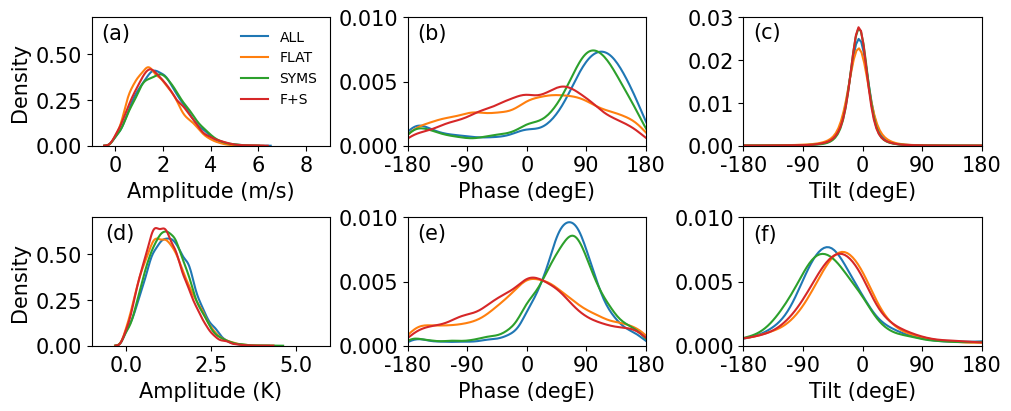

In [57]:
fig,ax = plot.subplots(2,3,figsize=(10,4),constrained_layout=True)
plot.rcParams['font.size'] = '15'

labels = ['ALL','FLAT','SYMS','F+S']


for s in range(4):
    sns.kdeplot(np.reshape(abs(v_all[s,1,:,8,:,:]),31*5*60),ax=ax[0,0],label=labels[s])
    ax[0,0].set_xlim([-1,9])
    ax[0,0].set_ylim([0,0.7])
    
    sns.kdeplot(np.reshape(abs(t_all[s,1,:,8,:,:]),31*5*60),ax=ax[1,0],label=labels[s])
    ax[1,0].set_xlim([-1,6])
    ax[1,0].set_ylim([0,0.7])
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,1,:,8,:,:])*180/np.pi,31*5*60),ax=ax[0,1])
    ax[0,1].set_xlim([-180,180])
    ax[0,1].set_ylim([0,0.01])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,1,:,8,:,:])*180/np.pi,31*5*60),ax=ax[1,1])
    ax[1,1].set_xlim([-180,180])
    ax[1,1].set_ylim([0,0.01])

    sns.kdeplot(np.reshape(np.real(v_phase[s,1,:,7,:,:]-v_phase[s,1,:,9,:,:])*180/np.pi,31*5*60),ax=ax[0,2],label=labels[s])
    ax[0,2].set_xlim([-180,180])
    ax[0,2].set_ylim([0,0.03])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,1,:,7,:,:]-t_phase[s,1,:,9,:,:])*180/np.pi,31*5*60),ax=ax[1,2],label=labels[s])
    ax[1,2].set_xlim([-180,180])
    ax[1,2].set_ylim([0,0.01])
    
    ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis

ax[0,0].text(-0.6,0.58,'(a)')
ax[0,1].text(-165,0.0083,'(b)')
ax[0,2].text(-165,0.025,'(c)')

ax[1,0].text(-0.6,0.58,'(d)')
ax[1,1].text(-165,0.0083,'(e)')
ax[1,2].text(-165,0.0082,'(f)')

ax[0,0].set_xticks([0,2,4,6,8])
ax[0,0].set_xticklabels([0,2,4,6,8]) 
ax[0,0].set_xlabel('Amplitude (m/s)')
#ax[1,0].set_xticks([0,3,6,9,12])
#ax[1,0].set_xticklabels([0,3,6,9,12]) 
ax[1,0].set_xlabel('Amplitude (K)')

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_xlabel('Phase (degE)')
ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_xlabel('Phase (degE)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_xlabel('Tilt (degE)')
ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_xlabel('Tilt (degE)')
ax[0,2].set_ylabel('') 
ax[1,2].set_ylabel('') 

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vn_new_300.png',dpi=600,bbox_inches='tight') 

# SH

In [33]:

simu = ['all','flat','syms','fs']

vbars = np.zeros((4,31,26,192,5,60))
tbars = np.zeros((4,31,26,192,5,60))

for s in range(4):
    print(s)
    
    for yy in range(30,90):
        #print(yy)
        filename2 = 'v.t.daily/'+simu[s]+'.s.'+str(yy)+'.nc'
        ncin1 = Dataset(filename2, 'r', format='NETCDF4') 
        v = ncin1.variables['v'] 
        v = (np.array(v))
        t = ncin1.variables['t'] 
        t = (np.array(t))
        
        vbars[s,:,:,:,:,yy-30] = v[:,:,:,4:9]
        tbars[s,:,:,:,:,yy-30] = t[:,:,:,4:9]
        #if yy!=30:
        #    vbars[s,:,:,:,2:5,yy-30-1] = v[:,:,:,0:3]
        #    tbars[s,:,:,:,2:5,yy-30-1] = t[:,:,:,0:3]
            
            
wmin = 0#8000
wmax = 5 #wavenumber
#rmax = 10#forcing years
#allfr = np.zeros((4,360*rmax),dtype = 'complex_')
v_all = np.zeros((4,wmax,31,26,5,60),dtype = 'complex_')
t_all = np.zeros((4,wmax,31,26,5,60),dtype = 'complex_')
v_phase = np.zeros((4,wmax,31,26,5,60),dtype = 'complex_')
t_phase = np.zeros((4,wmax,31,26,5,60),dtype = 'complex_')
f = np.zeros(wmax)

#epz[epz<0]=0 ######################################## do we want this????


for d in range(31):
    print(d)
    for h in range(26):
        for m in range(5):
            for y in range(60):
                for i in range(4):
                    signal = vbars[i,d,h,:,m,y]
                    #print(signal)
                    lon = np.arange(0,192,1)
                    period = len(lon)
                    for n in range(wmin,wmax):
                        #print(n)         
                        c = signal*np.exp(-1j*2*n*(np.pi*lon/period))
                        #print(c)
                        cn = c.sum()/c.size
                        #print(cn)
                        v_all[i,n,d,h,m,y] = cn
                        v_phase[i,n,d,h,m,y] = np.angle(cn)
                
for d in range(31):
    print(d)
    for h in range(26):
        for m in range(5):
            for y in range(60):
                for i in range(4):
                    signal = tbars[i,d,h,:,m,y]
                    lon = np.arange(0,192,1)
                    period = len(lon)
                    for n in range(wmin,wmax):
                        #print(n)         
                        c = signal*np.exp(-1j*2*n*(np.pi*lon/period))
                        cn = c.sum()/c.size
                        t_all[i,n,d,h,m,y] = cn
                        t_phase[i,n,d,h,m,y] = np.angle(cn)


0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


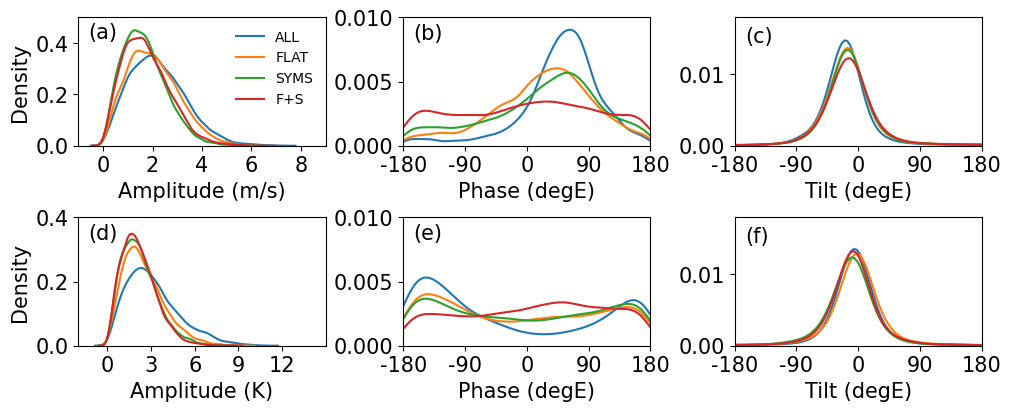

In [9]:
fig,ax = plot.subplots(2,3,figsize=(10,4),constrained_layout=True)
plot.rcParams['font.size'] = '15'

labels = ['ALL','FLAT','SYMS','F+S']


for s in range(4):
    sns.kdeplot(np.reshape(abs(v_all[s,1,:,12,:,:]),31*5*60),ax=ax[0,0],label=labels[s])
    ax[0,0].set_xlim([-1,9])
    ax[0,0].set_ylim([0,0.5])
    
    sns.kdeplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),ax=ax[1,0],label=labels[s])
    ax[1,0].set_xlim([-2,15])
    ax[1,0].set_ylim([0,0.4])
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),ax=ax[0,1])
    ax[0,1].set_xlim([-180,180])
    ax[0,1].set_ylim([0,0.01])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),ax=ax[1,1])
    ax[1,1].set_xlim([-180,180])
    ax[1,1].set_ylim([0,0.01])

    sns.kdeplot(np.reshape(np.real(v_phase[s,1,:,11,:,:]-v_phase[s,1,:,13,:,:])*180/np.pi,31*5*60),ax=ax[0,2],label=labels[s])
    ax[0,2].set_xlim([-180,180])
    ax[0,2].set_ylim([0,0.018])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,1,:,11,:,:]-t_phase[s,1,:,13,:,:])*180/np.pi,31*5*60),ax=ax[1,2],label=labels[s])
    ax[1,2].set_xlim([-180,180])
    ax[1,2].set_ylim([0,0.018])
    
    ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis

ax[0,0].text(-0.6,0.42,'(a)')
ax[0,1].text(-165,0.0083,'(b)')
ax[0,2].text(-165,0.0145,'(c)')

ax[1,0].text(-1.3,0.33,'(d)')
ax[1,1].text(-165,0.0083,'(e)')
ax[1,2].text(-165,0.0145,'(f)')

ax[0,0].set_xticks([0,2,4,6,8])
ax[0,0].set_xticklabels([0,2,4,6,8]) 
ax[0,0].set_xlabel('Amplitude (m/s)')
ax[1,0].set_xticks([0,3,6,9,12])
ax[1,0].set_xticklabels([0,3,6,9,12]) 
ax[1,0].set_xlabel('Amplitude (K)')

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_xlabel('Phase (degE)')
ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_xlabel('Phase (degE)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_xlabel('Tilt (degE)')
ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_xlabel('Tilt (degE)')
ax[0,2].set_ylabel('') 
ax[1,2].set_ylabel('') 

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vts_new.png',dpi=600,bbox_inches='tight') 

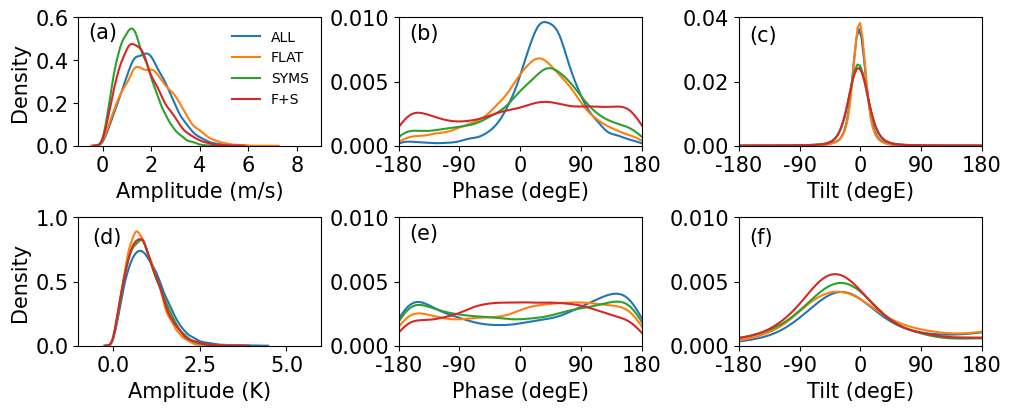

In [53]:
fig,ax = plot.subplots(2,3,figsize=(10,4),constrained_layout=True)
plot.rcParams['font.size'] = '15'

labels = ['ALL','FLAT','SYMS','F+S']


for s in range(4):
    sns.kdeplot(np.reshape(abs(v_all[s,1,:,9,:,:]),31*5*60),ax=ax[0,0],label=labels[s])
    ax[0,0].set_xlim([-1,9])
    ax[0,0].set_ylim([0,0.6])
    
    sns.kdeplot(np.reshape(abs(t_all[s,1,:,9,:,:]),31*5*60),ax=ax[1,0],label=labels[s])
    ax[1,0].set_xlim([-1,6])
    ax[1,0].set_ylim([0,1])
    
    sns.kdeplot(np.reshape(np.real(v_phase[s,1,:,9,:,:])*180/np.pi,31*5*60),ax=ax[0,1])
    ax[0,1].set_xlim([-180,180])
    ax[0,1].set_ylim([0,0.01])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,1,:,9,:,:])*180/np.pi,31*5*60),ax=ax[1,1])
    ax[1,1].set_xlim([-180,180])
    ax[1,1].set_ylim([0,0.01])

    sns.kdeplot(np.reshape(np.real(v_phase[s,1,:,8,:,:]-v_phase[s,1,:,10,:,:])*180/np.pi,31*5*60),ax=ax[0,2],label=labels[s])
    ax[0,2].set_xlim([-180,180])
    ax[0,2].set_ylim([0,0.04])
    
    sns.kdeplot(np.reshape(np.real(t_phase[s,1,:,8,:,:]-t_phase[s,1,:,10,:,:])*180/np.pi,31*5*60),ax=ax[1,2],label=labels[s])
    ax[1,2].set_xlim([-180,180])
    ax[1,2].set_ylim([0,0.01])
    
    ax[0,0].legend( loc='upper right',fontsize=10,frameon=False)
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis

ax[0,0].text(-0.6,0.5,'(a)')
ax[0,1].text(-165,0.0083,'(b)')
ax[0,2].text(-165,0.0325,'(c)')

ax[1,0].text(-0.6,0.8,'(d)')
ax[1,1].text(-165,0.0083,'(e)')
ax[1,2].text(-165,0.008,'(f)')

ax[0,0].set_xticks([0,2,4,6,8])
ax[0,0].set_xticklabels([0,2,4,6,8]) 
ax[0,0].set_xlabel('Amplitude (m/s)')
#ax[1,0].set_xticks([0,3,6,9,12])
#ax[1,0].set_xticklabels([0,3,6,9,12]) 
ax[1,0].set_xlabel('Amplitude (K)')

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_xlabel('Phase (degE)')
ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_xlabel('Phase (degE)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_xlabel('Tilt (degE)')
ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_xlabel('Tilt (degE)')
ax[0,2].set_ylabel('') 
ax[1,2].set_ylabel('') 

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vts_new_300.png',dpi=600,bbox_inches='tight') 

In [6]:
plev[13]/100

70.0

In [50]:
print(skew(np.reshape(abs(v_all[i,1,:,12,:,:]),31*5*60),nan_policy='omit'))

0.32569514307079134


In [16]:
[d,p]=ks_2samp(np.reshape(np.real(v_phase[0,1,0:30,12,:,:])*180/np.pi,30*5*60),np.reshape(np.real(v_phase[1,1,0:30,12,:,:])*180/np.pi,30*5*60))
print(p)

3.267545531711626e-189


<Axes: >

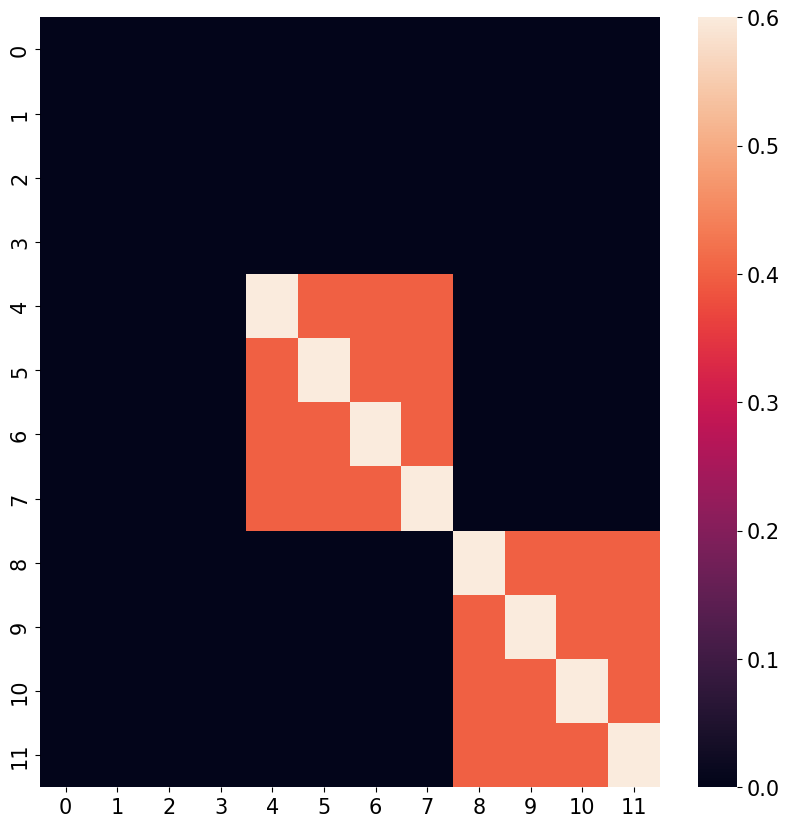

In [62]:
from scipy.stats import ks_2samp

ht = np.zeros((12,12))

for i in range(4):
    for j in range(4):
        [d,p]=ks_2samp(np.reshape(abs(v_all[i,1,:,12,:,:]),31*5*60), np.reshape(abs(v_all[j,1,:,12,:,:]),31*5*60))
#         if p>0.05:
#             ht[i,j] = 0.6
#         else:
#             ht[i,j] = 0.4

for i in range(4):
    for j in range(4):
        [d,p]=ks_2samp(np.reshape(np.real(v_phase[i,1,:,12,:,:])*180/np.pi,31*5*60),np.reshape(np.real(v_phase[j,1,:,12,:,:])*180/np.pi,31*5*60))
        if p>0.05:
            ht[i+4,j+4] = 0.6
        else:
            ht[i+4,j+4] = 0.4
        
for i in range(4):
    for j in range(4):
        [d,p]=ks_2samp(np.reshape(np.real(v_phase[i,1,:,11,:,:]-v_phase[i,1,:,13,:,:])*180/np.pi,31*5*60), np.reshape(np.real(v_phase[j,1,:,11,:,:]-v_phase[j,1,:,13,:,:])*180/np.pi,31*5*60))
        if p>0.05:
            ht[i+8,j+8] = 0.6
        else:
            ht[i+8,j+8] = 0.4


fig.ax = plot.subplots(figsize=(10,10))
sns.heatmap(ht)
        
# if p<0.05:
#     ax[xx].text(52,220,'pvalue<0.05')
# else:
#     ax[xx].text(52,220,'pvalue>0.05')
#ax[xx].text(75,110,'pvalue = '+str("%e"%round(p,10)))



In [88]:
from scipy.stats import ttest_ind

[d,p]=ks_2samp(np.reshape(abs(v_all[0,1,:,12,:,:]),31*5*60)[7900:8000], np.reshape(abs(v_all[2,1,:,12,:,:]),31*5*60)[7900:8000])
print(p)

[d,p]=ttest_ind(np.reshape(np.real(v_phase[0,1,:,12,:,:])*180/np.pi,31*5*60),\
         np.reshape(np.real(v_phase[2,1,:,12,:,:])*180/np.pi,31*5*60),nan_policy='omit')
print(p)

0.469506448503778
7.607997253553244e-05


In [71]:
np.reshape(np.real(v_phase[1,1,:,12,:,:])*180/np.pi,31*5*60)[0:50]

array([  40.74310881,  -79.52856905,   13.74962779,   -8.32106654,
         90.17592103,  149.8863048 ,  174.37723273,   50.96770657,
         74.65624704,  131.88985583,  -54.78227299,  151.11455176,
        111.84441526,   62.23879578,  -79.99503151, -168.18222567,
         83.75280257,   52.945292  ,  107.71656947,   20.9743163 ,
       -170.1481683 ,  106.78912059,    2.25902598,   -2.60200916,
        -44.15331992,  -21.28079769,  -83.29249634,   80.02046969,
       -109.96285808,  109.5402544 ,   21.45564726,  -31.80863138,
        139.63137904,  137.35598476,  164.37511328,  134.80943701,
        177.16161478,  -67.12538086,   47.33649725,   56.16415963,
        170.94770646,   57.58218817,    6.90162852,  103.39508835,
         65.86503883,  148.29953773,   88.49469698,  -28.02984351,
        -58.84117579, -111.86828264])

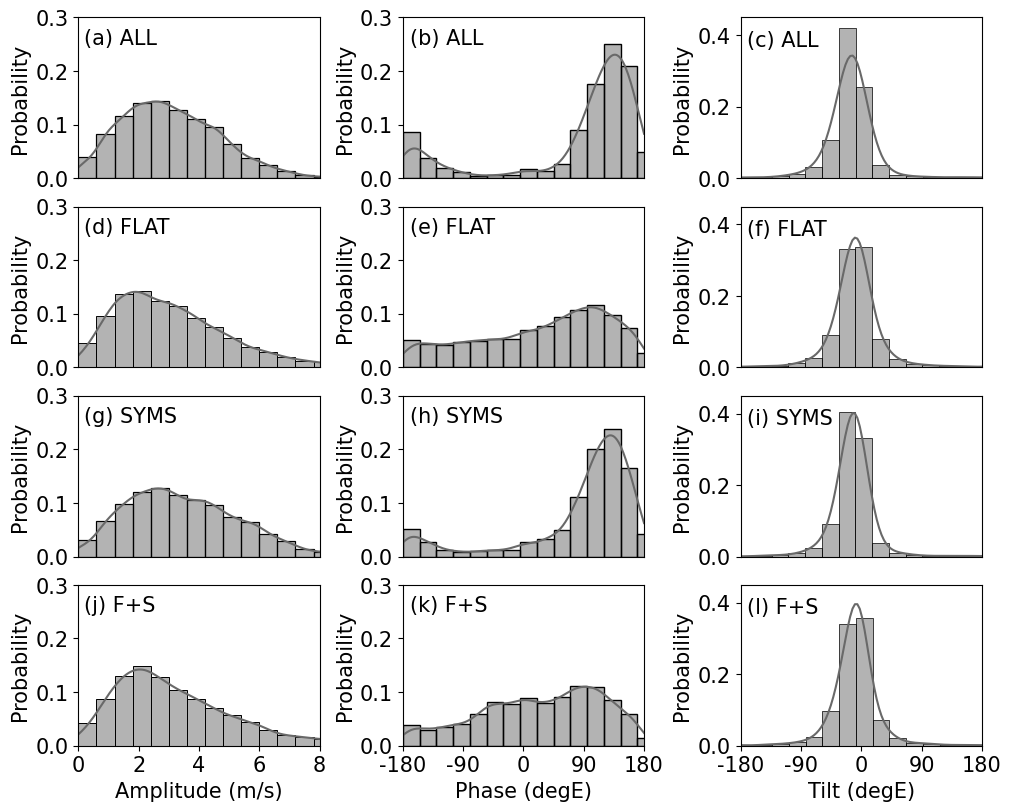

In [11]:
fig,ax = plot.subplots(4,3,figsize=(10,8),constrained_layout=True)
plot.rcParams['font.size'] = '15'


for s in range(4):
    sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
                 binwidth = 0.6,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,0],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,0].set_xlim([0,8])
    ax[s,0].set_ylim([0,0.3])
    
#     sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
#                  binwidth = 1,
#                   kde=True,ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,1].set_xlim([0,13])
#     ax[s,1].set_ylim([0,0.35])
    
    sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
                 binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,1].set_xlim([-180,180])
    ax[s,1].set_ylim([0,0.3])

    sns.histplot(np.reshape(np.real(t_phase[s,1,:,11,:,:]-t_phase[s,1,:,13,:,:])*180/np.pi,31*5*60),
                 binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,2],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,2].set_xlim([-180,180])
    ax[s,2].set_ylim([0,0.45])
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']
    
for i in range(4):
     for j in range(3):
            if j==0:
                ax[i,j].text(0.2,0.25,num[i][j]+' '+sim[i])
            if j==1:
                ax[i,j].text(-170,0.25,num[i][j]+' '+sim[i])
            if j==2:
                ax[i,j].text(-170,0.37,num[i][j]+' '+sim[i])
#         if i==0:
#             ax[i,j].text(4,0.4,wave[j])
#         if j==0:
#             #ax[i,j].set_yticks(yyy)
#             #ax[i,j].set_yticklabels(yy) 
#             ax[i,j].set_ylabel('Probability')
#         else:
#             ax[i,j].set_yticks([])
#             ax[i,j].set_yticklabels([]) 
            if i==3:
                if j==0:
                    ax[i,j].set_xticks([0,2,4,6,8])
                    ax[i,j].set_xticklabels([0,2,4,6,8])  
                    ax[i,j].set_xlabel('Amplitude (m/s)')
                elif j==1:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Phase (degE)')
                else:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Tilt (degE)')                
            else:
                ax[i,j].set_xticks([])
                ax[i,j].set_xticklabels([])  

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/tn.png',dpi=600,bbox_inches='tight') 

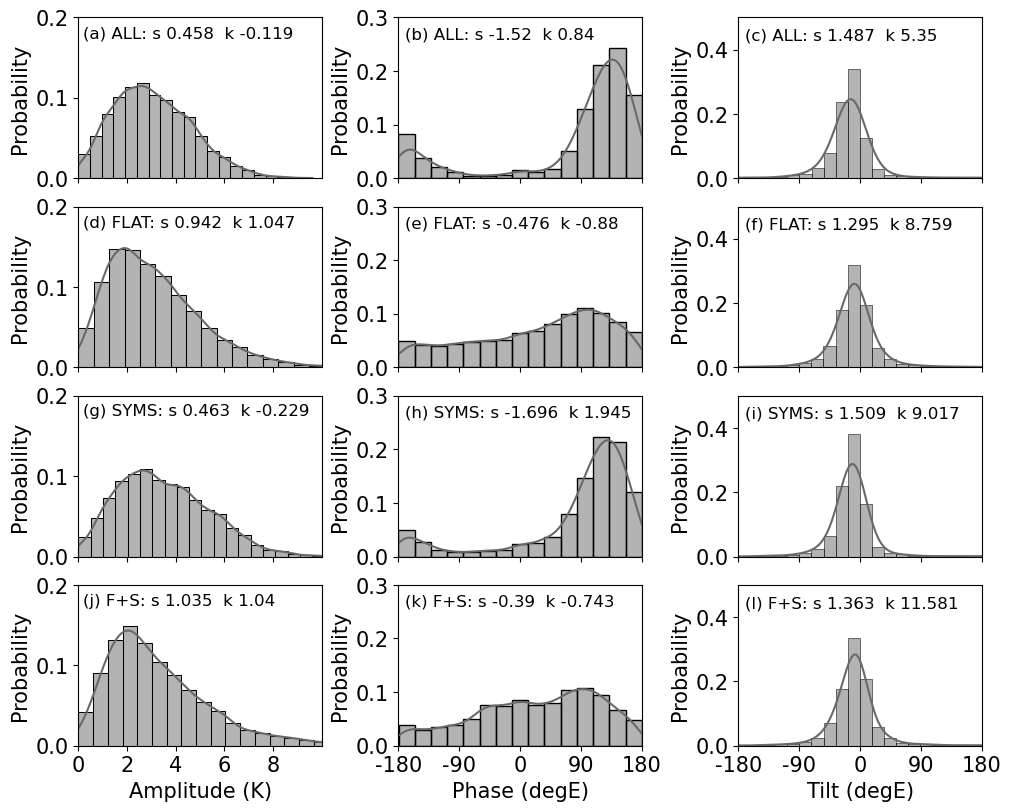

In [107]:
fig,ax = plot.subplots(4,3,figsize=(10,8),constrained_layout=True)
plot.rcParams['font.size'] = '15'


for s in range(4):
    sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
                 bins=20,#binwidth = 0.6,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,0],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,0].set_xlim([0,10])
    ax[s,0].set_ylim([0,0.2])
    
#     sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
#                  binwidth = 1,
#                   kde=True,ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,1].set_xlim([0,13])
#     ax[s,1].set_ylim([0,0.35])
    
    sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
                 bins=15,#binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,1].set_xlim([-180,180])
    ax[s,1].set_ylim([0,0.3])

    sns.histplot(np.reshape(np.real(t_phase[s,1,:,11,:,:]-t_phase[s,1,:,13,:,:])*180/np.pi,31*5*60),
                 bins=40,#binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,2],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,2].set_xlim([-180,180])
    ax[s,2].set_ylim([0,0.5])
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis
    
for i in range(4):
     for j in range(3):
            if j==0:
                ax[i,j].text(0.2,0.175,num[i][j]+' '+sim[i]+': s ' \
                             +str(round(skew(np.reshape(abs(t_all[i,1,:,12,:,:]),31*5*60),nan_policy='omit'),3)) \
                             +'  k '\
                             +str(round(kurtosis(np.reshape(abs(t_all[i,1,:,12,:,:]),31*5*60),nan_policy='omit'),3))\
                             ,size=12)
            if j==1:
                ax[i,j].text(-170,0.26,num[i][j]+' '+sim[i]+': s '\
                             +str(round(skew(np.reshape(np.real(t_phase[i,1,:,12,:,:])*180/np.pi,31*5*60)\
                                             ,nan_policy='omit'),3))+'  k '+\
                             str(round(kurtosis(np.reshape(np.real(t_phase[i,1,:,12,:,:])*180/np.pi,31*5*60)\
                                                ,nan_policy='omit'),3)),size=12)
            if j==2:
                ax[i,j].text(-170,0.43,num[i][j]+' '+sim[i]+': s '\
                             +str(round(skew(np.reshape(np.real(t_phase[i,1,:,11,:,:]-t_phase[i,1,:,13,:,:])*180/ \
                                                        np.pi,31*5*60),nan_policy='omit'),3))+'  k '+\
                             str(round(kurtosis(np.reshape(np.real(t_phase[i,1,:,11,:,:]-t_phase[i,1,:,13,:,:])*180/ \
                                                           np.pi,31*5*60),nan_policy='omit'),3)),size=12)
 
            if i==3:
                if j==0:
                    ax[i,j].set_xticks([0,2,4,6,8])
                    ax[i,j].set_xticklabels([0,2,4,6,8])  
                    ax[i,j].set_xlabel('Amplitude (K)')
                elif j==1:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Phase (degE)')
                else:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Tilt (degE)') 
            elif j==0:
                ax[i,j].set_xticks([0,2,4,6,8])
                ax[i,j].set_xticklabels([])
            if i<3:
                if j>0:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels([])  

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/tn.png',dpi=600,bbox_inches='tight') 

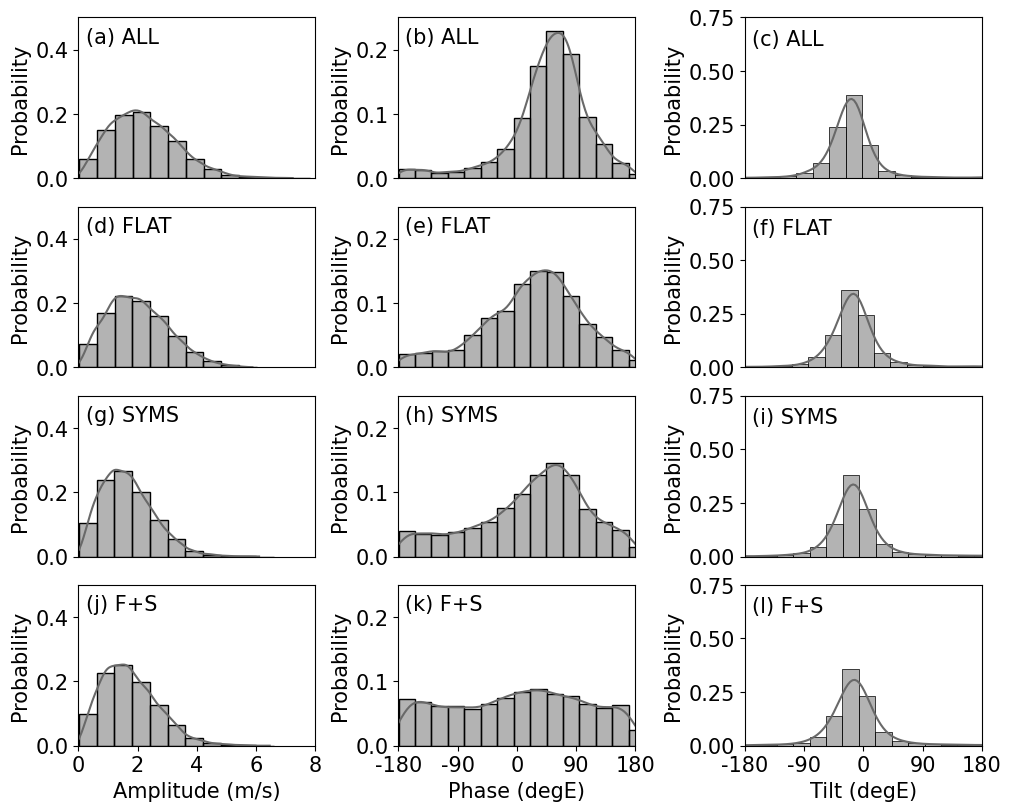

In [8]:
fig,ax = plot.subplots(4,3,figsize=(10,8),constrained_layout=True)
plot.rcParams['font.size'] = '15'


for s in range(4):
    sns.histplot(np.reshape(abs(v_all[s,1,:,12,:,:]),31*5*60),
                 binwidth = 0.6,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,0],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,0].set_xlim([0,8])
    ax[s,0].set_ylim([0,0.5])
    
#     sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
#                  binwidth = 1,
#                   kde=True,ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,1].set_xlim([0,13])
#     ax[s,1].set_ylim([0,0.35])
    
    sns.histplot(np.reshape(np.real(v_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
                 binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,1].set_xlim([-180,180])
    ax[s,1].set_ylim([0,0.25])

    sns.histplot(np.reshape(np.real(v_phase[s,1,:,11,:,:]-v_phase[s,1,:,13,:,:])*180/np.pi,31*5*60),
                 binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,2],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,2].set_xlim([-180,180])
    ax[s,2].set_ylim([0,0.75])
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']
    
for i in range(4):
     for j in range(3):
            if j==0:
                ax[i,j].text(0.24,0.42,num[i][j]+' '+sim[i])
            if j==1:
                ax[i,j].text(-170,0.21,num[i][j]+' '+sim[i])
            if j==2:
                ax[i,j].text(-170,0.62,num[i][j]+' '+sim[i])
#         if i==0:
#             ax[i,j].text(4,0.4,wave[j])
#         if j==0:
#             #ax[i,j].set_yticks(yyy)
#             #ax[i,j].set_yticklabels(yy) 
#             ax[i,j].set_ylabel('Probability')
#         else:
#             ax[i,j].set_yticks([])
#             ax[i,j].set_yticklabels([]) 
            if i==3:
                if j==0:
                    ax[i,j].set_xticks([0,2,4,6,8])
                    ax[i,j].set_xticklabels([0,2,4,6,8])  
                    ax[i,j].set_xlabel('Amplitude (m/s)')
                elif j==1:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Phase (degE)')
                else:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Tilt (degE)')                
            else:
                ax[i,j].set_xticks([])
                ax[i,j].set_xticklabels([])  

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vs.png',dpi=600,bbox_inches='tight') 

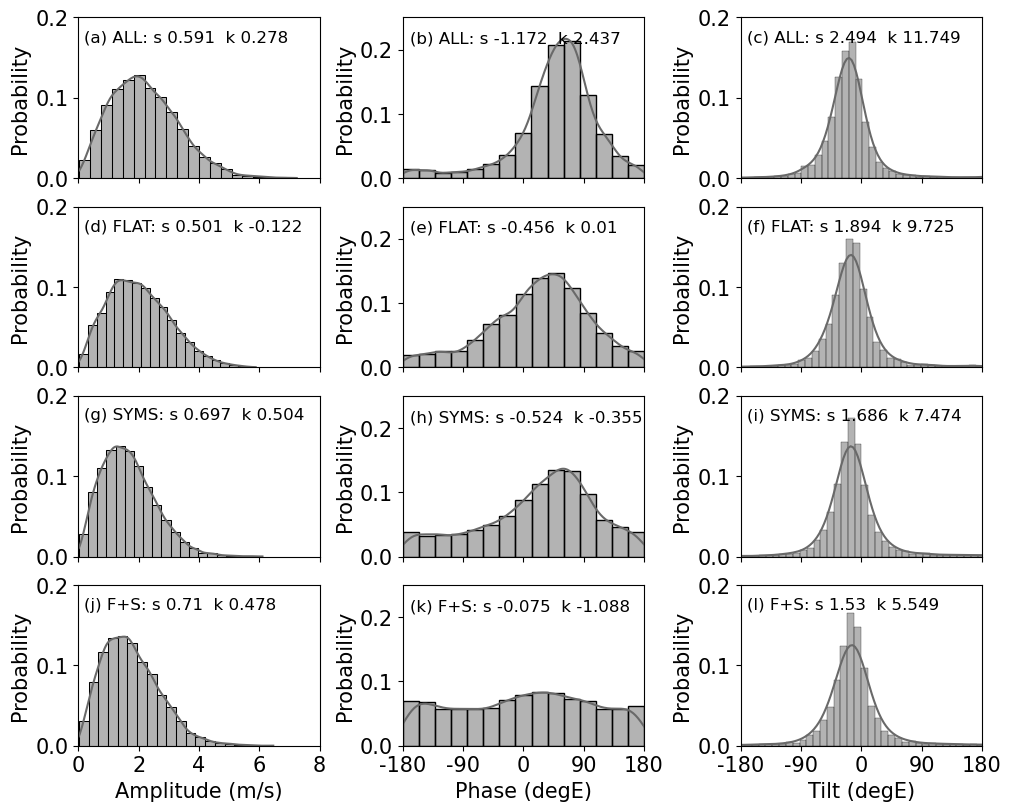

In [109]:
fig,ax = plot.subplots(4,3,figsize=(10,8),constrained_layout=True)
plot.rcParams['font.size'] = '15'


for s in range(4):
    sns.histplot(np.reshape(abs(v_all[s,1,:,12,:,:]),31*5*60),
                 bins=20,#binwidth = 0.6,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,0],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,0].set_xlim([0,8])
    ax[s,0].set_ylim([0,0.2])
    
#     sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
#                  binwidth = 1,
#                   kde=True,ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,1].set_xlim([0,13])
#     ax[s,1].set_ylim([0,0.35])
    
    sns.histplot(np.reshape(np.real(v_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
                 bins=15,#binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,1].set_xlim([-180,180])
    ax[s,1].set_ylim([0,0.25])

    sns.histplot(np.reshape(np.real(v_phase[s,1,:,11,:,:]-v_phase[s,1,:,13,:,:])*180/np.pi,31*5*60),
                 bins=70,#binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,2],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,2].set_xlim([-180,180])
    ax[s,2].set_ylim([0,0.2])
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis
    
for i in range(4):
     for j in range(3):
            if j==0:
                ax[i,j].text(0.2,0.17,num[i][j]+' '+sim[i]+': s ' \
                             +str(round(skew(np.reshape(abs(v_all[i,1,:,12,:,:]),31*5*60),nan_policy='omit'),3)) \
                             +'  k '\
                             +str(round(kurtosis(np.reshape(abs(v_all[i,1,:,12,:,:]),31*5*60),nan_policy='omit'),3))\
                             ,size=12)
            if j==1:
                ax[i,j].text(-170,0.21,num[i][j]+' '+sim[i]+': s '\
                             +str(round(skew(np.reshape(np.real(v_phase[i,1,:,12,:,:])*180/np.pi,31*5*60)\
                                             ,nan_policy='omit'),3))+'  k '+\
                             str(round(kurtosis(np.reshape(np.real(v_phase[i,1,:,12,:,:])*180/np.pi,31*5*60)\
                                                ,nan_policy='omit'),3)),size=12)
            if j==2:
                ax[i,j].text(-170,0.17,num[i][j]+' '+sim[i]+': s '\
                             +str(round(skew(np.reshape(np.real(v_phase[i,1,:,11,:,:]-v_phase[i,1,:,13,:,:])*180/ \
                                                        np.pi,31*5*60),nan_policy='omit'),3))+'  k '+\
                             str(round(kurtosis(np.reshape(np.real(v_phase[i,1,:,11,:,:]-v_phase[i,1,:,13,:,:])*180/ \
                                                           np.pi,31*5*60),nan_policy='omit'),3)),size=12)
#         if i==0:
#             ax[i,j].text(4,0.4,wave[j])
#         if j==0:
#             #ax[i,j].set_yticks(yyy)
#             #ax[i,j].set_yticklabels(yy) 
#             ax[i,j].set_ylabel('Probability')
#         else:
#             ax[i,j].set_yticks([])
#             ax[i,j].set_yticklabels([]) 
            if i==3:
                if j==0:
                    ax[i,j].set_xticks([0,2,4,6,8])
                    ax[i,j].set_xticklabels([0,2,4,6,8])  
                    ax[i,j].set_xlabel('Amplitude (m/s)')
                elif j==1:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Phase (degE)')
                else:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Tilt (degE)') 
            elif j==0:
                ax[i,j].set_xticks([0,2,4,6,8])
                ax[i,j].set_xticklabels([])
            if i<3:
                if j>0:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels([])  

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vs.png',dpi=600,bbox_inches='tight') 

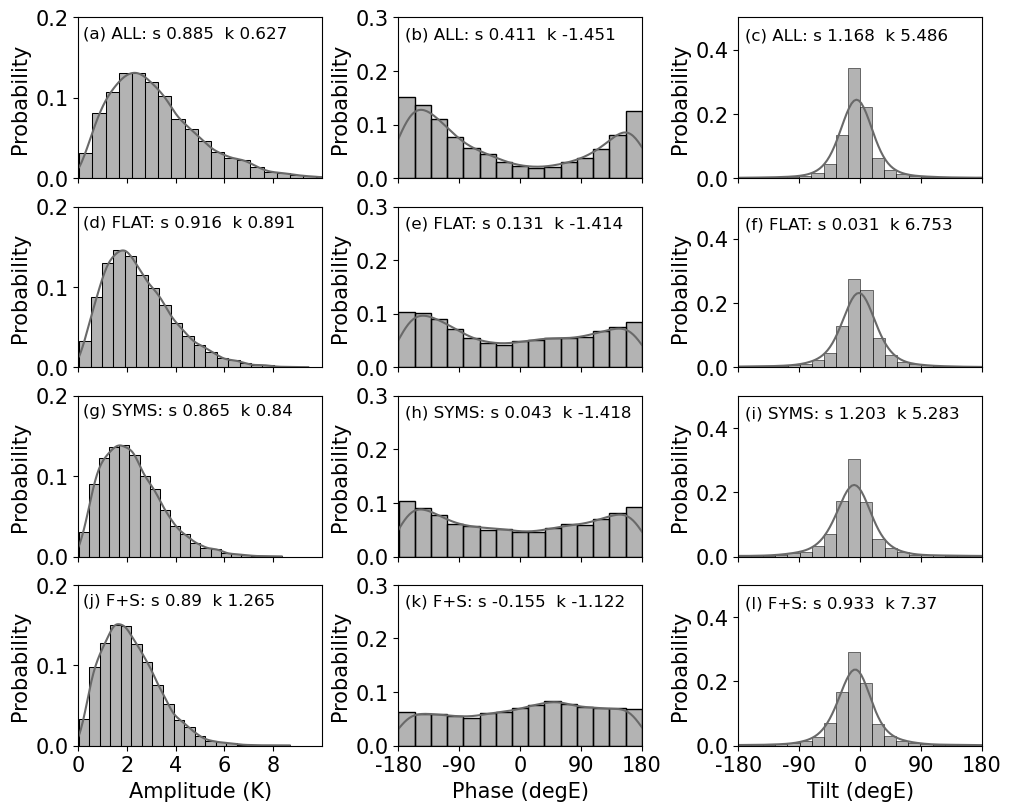

In [110]:
fig,ax = plot.subplots(4,3,figsize=(10,8),constrained_layout=True)
plot.rcParams['font.size'] = '15'


for s in range(4):
    sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
                 bins=20,#binwidth = 0.6,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,0],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,0].set_xlim([0,10])
    ax[s,0].set_ylim([0,0.2])
    
#     sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
#                  binwidth = 1,
#                   kde=True,ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,1].set_xlim([0,13])
#     ax[s,1].set_ylim([0,0.35])
    
    sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
                 bins=15,#binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,1].set_xlim([-180,180])
    ax[s,1].set_ylim([0,0.3])

    sns.histplot(np.reshape(np.real(t_phase[s,1,:,11,:,:]-t_phase[s,1,:,13,:,:])*180/np.pi,31*5*60),
                 bins=40,#binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,2],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,2].set_xlim([-180,180])
    ax[s,2].set_ylim([0,0.5])
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']

from scipy.stats import skew
from scipy.stats import kurtosis
    
for i in range(4):
     for j in range(3):
            if j==0:
                ax[i,j].text(0.2,0.175,num[i][j]+' '+sim[i]+': s ' \
                             +str(round(skew(np.reshape(abs(t_all[i,1,:,12,:,:]),31*5*60),nan_policy='omit'),3)) \
                             +'  k '\
                             +str(round(kurtosis(np.reshape(abs(t_all[i,1,:,12,:,:]),31*5*60),nan_policy='omit'),3))\
                             ,size=12)
            if j==1:
                ax[i,j].text(-170,0.26,num[i][j]+' '+sim[i]+': s '\
                             +str(round(skew(np.reshape(np.real(t_phase[i,1,:,12,:,:])*180/np.pi,31*5*60)\
                                             ,nan_policy='omit'),3))+'  k '+\
                             str(round(kurtosis(np.reshape(np.real(t_phase[i,1,:,12,:,:])*180/np.pi,31*5*60)\
                                                ,nan_policy='omit'),3)),size=12)
            if j==2:
                ax[i,j].text(-170,0.43,num[i][j]+' '+sim[i]+': s '\
                             +str(round(skew(np.reshape(np.real(t_phase[i,1,:,11,:,:]-t_phase[i,1,:,13,:,:])*180/ \
                                                        np.pi,31*5*60),nan_policy='omit'),3))+'  k '+\
                             str(round(kurtosis(np.reshape(np.real(t_phase[i,1,:,11,:,:]-t_phase[i,1,:,13,:,:])*180/ \
                                                           np.pi,31*5*60),nan_policy='omit'),3)),size=12)
 
            if i==3:
                if j==0:
                    ax[i,j].set_xticks([0,2,4,6,8])
                    ax[i,j].set_xticklabels([0,2,4,6,8])  
                    ax[i,j].set_xlabel('Amplitude (K)')
                elif j==1:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Phase (degE)')
                else:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Tilt (degE)') 
            elif j==0:
                ax[i,j].set_xticks([0,2,4,6,8])
                ax[i,j].set_xticklabels([])
            if i<3:
                if j>0:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels([])  

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/ts.png',dpi=600,bbox_inches='tight') 

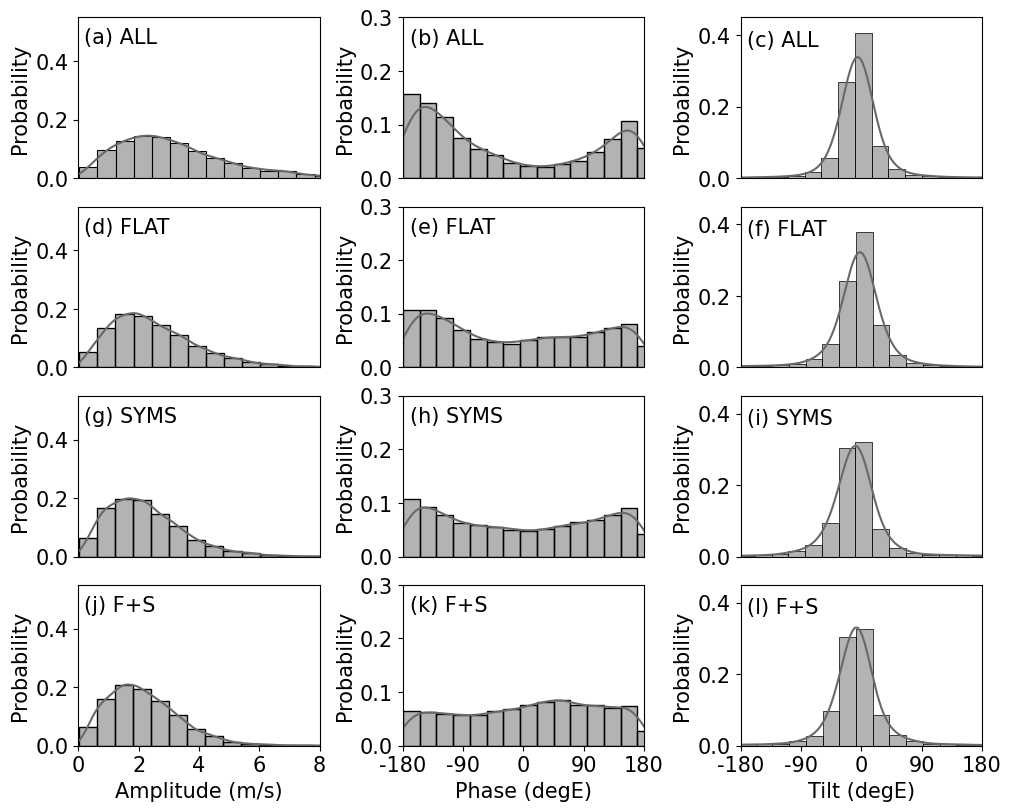

In [9]:
fig,ax = plot.subplots(4,3,figsize=(10,8),constrained_layout=True)
plot.rcParams['font.size'] = '15'


for s in range(4):
    sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
                 binwidth = 0.6,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,0],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,0].set_xlim([0,8])
    ax[s,0].set_ylim([0,0.55])
    
#     sns.histplot(np.reshape(abs(t_all[s,1,:,12,:,:]),31*5*60),
#                  binwidth = 1,
#                   kde=True,ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,1].set_xlim([0,13])
#     ax[s,1].set_ylim([0,0.35])
    
    sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
                 binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,1],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,1].set_xlim([-180,180])
    ax[s,1].set_ylim([0,0.3])

    sns.histplot(np.reshape(np.real(t_phase[s,1,:,11,:,:]-t_phase[s,1,:,13,:,:])*180/np.pi,31*5*60),
                 binwidth = 25,#alpha = 0.2,
                  kde=True,line_kws={'color':'red'},ax=ax[s,2],color='dimgrey',edgecolor='black',stat='probability')
    ax[s,2].set_xlim([-180,180])
    ax[s,2].set_ylim([0,0.45])
    
#     sns.histplot(np.reshape(np.real(t_phase[s,1,:,12,:,:])*180/np.pi,31*5*60),
#                  binwidth = 30,
#                   kde=True,ax=ax[s,3],color='dimgrey',edgecolor='black',stat='probability')
#     ax[s,3].set_xlim([-180,180])
#     ax[s,3].set_ylim([0,0.35])

xx = [-180,-90,0,90,180]
xxx = [-180,-90,0,90,180]
#yy = [1000,500,100,10,1]
#yyy = [0,6,12,17,22]

num = [['(a)','(b)','(c)'],
   ['(d)','(e)','(f)'],
   ['(g)','(h)','(i)'],
   ['(j)','(k)','(l)']]
sim = ['ALL','FLAT','SYMS','F+S']
wave = ['wave 1','wave 2','wave 3','wave 4']
    
for i in range(4):
     for j in range(3):
            if j==0:
                ax[i,j].text(0.2,0.46,num[i][j]+' '+sim[i])
            if j==1:
                ax[i,j].text(-170,0.25,num[i][j]+' '+sim[i])
            if j==2:
                ax[i,j].text(-170,0.37,num[i][j]+' '+sim[i])
#         if i==0:
#             ax[i,j].text(4,0.4,wave[j])
#         if j==0:
#             #ax[i,j].set_yticks(yyy)
#             #ax[i,j].set_yticklabels(yy) 
#             ax[i,j].set_ylabel('Probability')
#         else:
#             ax[i,j].set_yticks([])
#             ax[i,j].set_yticklabels([]) 
            if i==3:
                if j==0:
                    ax[i,j].set_xticks([0,2,4,6,8])
                    ax[i,j].set_xticklabels([0,2,4,6,8])  
                    ax[i,j].set_xlabel('Amplitude (m/s)')
                elif j==1:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Phase (degE)')
                else:
                    ax[i,j].set_xticks(xxx)
                    ax[i,j].set_xticklabels(xx)  
                    ax[i,j].set_xlabel('Tilt (degE)')                
            else:
                ax[i,j].set_xticks([])
                ax[i,j].set_xticklabels([])  

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/ts.png',dpi=600,bbox_inches='tight') 

/tmp/ipykernel_28423/2251737687.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


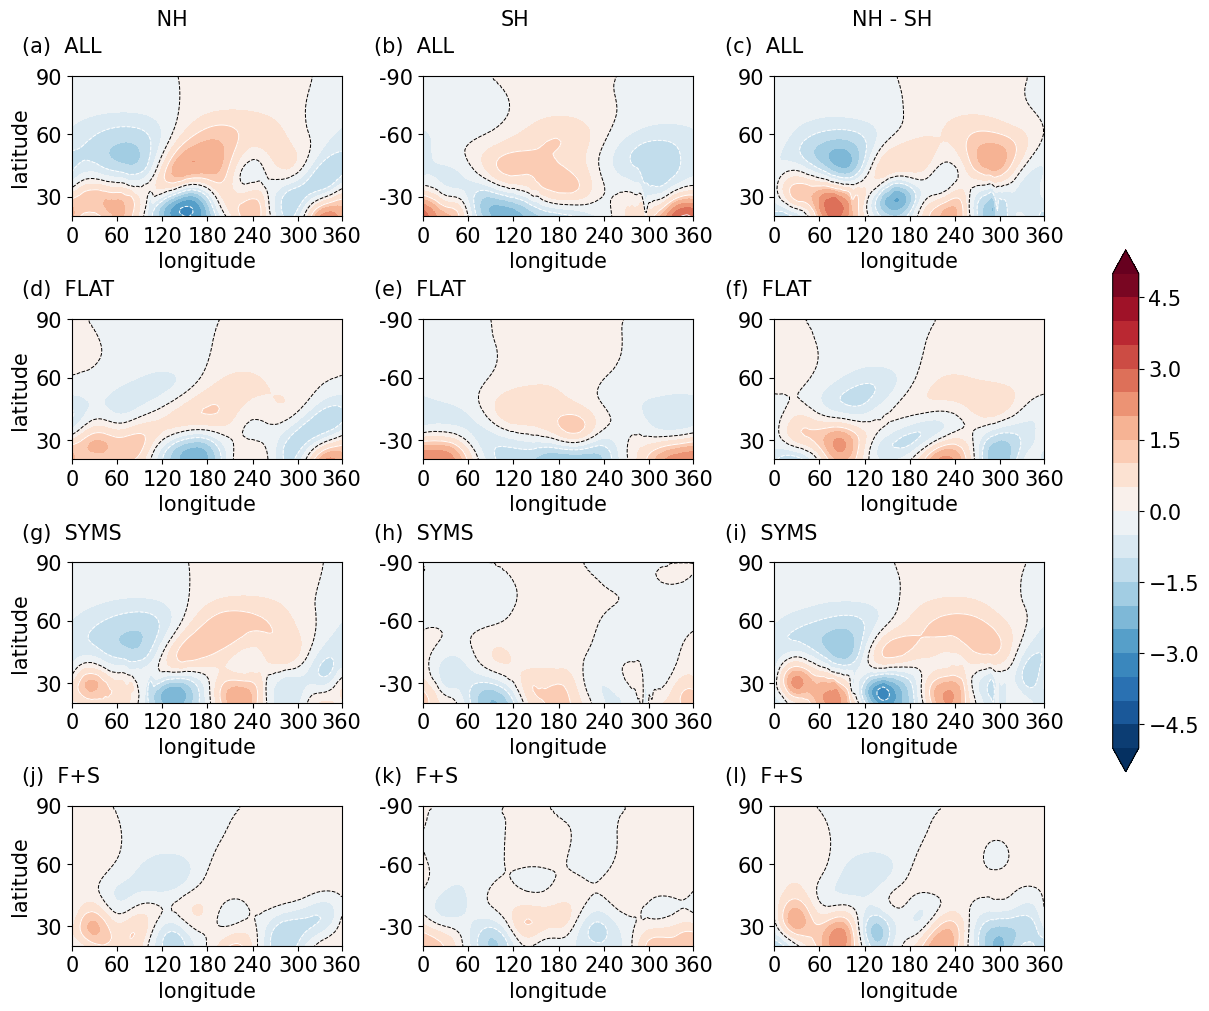

In [67]:
fig,ax = plot.subplots(4,3,figsize=(12,10),constrained_layout=True)#,projection=ccrs.PlateCarree())
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-5,5.5,0.5)
cll = np.arange(-5,6,2)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0,0].set_xticks(xxx)
ax[0,0].set_xticklabels(xx)
ax[0,0].set_yticks(yyy)
ax[0,0].set_yticklabels(yy)
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('latitude')
ax[0,0].text(-35,53,'(a)  ALL')
ax[0,0].text(55,60,' NH')
ax[0,0].set_ylim(11,47)


p1=ax[0,0].contourf(x,y,tplre[0,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,tplre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[0,0].contour(x,y,tplre[0,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p1=ax[0,0].contour(x,y,tplre[0,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_yticks(yyy)
ax[0,1].set_yticklabels(yy)
ax[0,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[0,1].text(-35,53,'(b)  ALL')
ax[0,1].text(55,60,'SH')
ax[0,1].set_ylim(11,47)

p2=ax[0,1].contourf(x,y,tpl[0,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[0,1].contour(x,y,tpl[0,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[0,1].contour(x,y,tpl[0,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_yticks(yyy)
ax[0,2].set_yticklabels(yy)
ax[0,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[0,2].text(-35,53,'(c)  ALL')
ax[0,2].text(55,60,'NH - SH')
ax[0,2].set_ylim(11,47)

p2=ax[0,2].contourf(x,y,-tpl[0,48:96,:,12]+tplre[0,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
plot.colorbar(p2,ax=ax.ravel().tolist(),shrink=0.6)
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[0,2].contour(x,y,-tpl[0,48:96,:,12]+tplre[0,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[0,2].contour(x,y,-tpl[0,48:96,:,12]+tplre[0,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')




ax[1,0].set_xticks(xxx)
ax[1,0].set_xticklabels(xx)
ax[1,0].set_yticks(yyy)
ax[1,0].set_yticklabels(yy)
ax[1,0].set_xlabel('longitude')
ax[1,0].set_ylabel('latitude')
ax[1,0].text(-35,53,'(d)  FLAT')
ax[1,0].set_ylim(11,47)


p1=ax[1,0].contourf(x,y,tplre[1,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,tplre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[1,0].contour(x,y,tplre[1,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p1=ax[1,0].contour(x,y,tplre[1,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_yticks(yyy)
ax[1,1].set_yticklabels(yy)
ax[1,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[1,1].text(-35,53,'(e)  FLAT')
ax[1,1].set_ylim(11,47)

p2=ax[1,1].contourf(x,y,tpl[1,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1,1].contour(x,y,tpl[1,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[1,1].contour(x,y,tpl[1,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_yticks(yyy)
ax[1,2].set_yticklabels(yy)
ax[1,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[1,2].text(-35,53,'(f)  FLAT')
ax[1,2].set_ylim(11,47)

p2=ax[1,2].contourf(x,y,-tpl[1,48:96,:,12]+tplre[1,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1,2].contour(x,y,-tpl[1,48:96,:,12]+tplre[1,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[1,2].contour(x,y,-tpl[1,48:96,:,12]+tplre[1,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')





ax[2,0].set_xticks(xxx)
ax[2,0].set_xticklabels(xx)
ax[2,0].set_yticks(yyy)
ax[2,0].set_yticklabels(yy)
ax[2,0].set_xlabel('longitude')
ax[2,0].set_ylabel('latitude')
ax[2,0].text(-35,53,'(g)  SYMS')
ax[2,0].set_ylim(11,47)


p1=ax[2,0].contourf(x,y,tplre[2,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,tplre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[2,0].contour(x,y,tplre[2,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p1=ax[2,0].contour(x,y,tplre[2,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[2,1].set_xticks(xxx)
ax[2,1].set_xticklabels(xx)
ax[2,1].set_yticks(yyy)
ax[2,1].set_yticklabels(yy)
ax[2,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[2,1].text(-35,53,'(h)  SYMS')
ax[2,1].set_ylim(11,47)

p2=ax[2,1].contourf(x,y,tpl[2,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[2,1].contour(x,y,tpl[2,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[2,1].contour(x,y,tpl[2,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[2,2].set_xticks(xxx)
ax[2,2].set_xticklabels(xx)
ax[2,2].set_yticks(yyy)
ax[2,2].set_yticklabels(yy)
ax[2,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[2,2].text(-35,53,'(i)  SYMS')
ax[2,2].set_ylim(11,47)

p2=ax[2,2].contourf(x,y,-tpl[2,48:96,:,12]+tplre[2,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[2,2].contour(x,y,-tpl[2,48:96,:,12]+tplre[2,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[2,2].contour(x,y,-tpl[2,48:96,:,12]+tplre[2,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')





ax[3,0].set_xticks(xxx)
ax[3,0].set_xticklabels(xx)
ax[3,0].set_yticks(yyy)
ax[3,0].set_yticklabels(yy)
ax[3,0].set_xlabel('longitude')
ax[3,0].set_ylabel('latitude')
ax[3,0].text(-35,53,'(j)  F+S')
ax[3,0].set_ylim(11,47)


p1=ax[3,0].contourf(x,y,tplre[3,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,tplre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[3,0].contour(x,y,tplre[3,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p1=ax[3,0].contour(x,y,tplre[3,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[3,1].set_xticks(xxx)
ax[3,1].set_xticklabels(xx)
ax[3,1].set_yticks(yyy)
ax[3,1].set_yticklabels(yy)
ax[3,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[3,1].text(-35,53,'(k)  F+S')
ax[3,1].set_ylim(11,47)

p2=ax[3,1].contourf(x,y,tpl[3,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[3,1].contour(x,y,tpl[3,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[3,1].contour(x,y,tpl[3,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[3,2].set_xticks(xxx)
ax[3,2].set_xticklabels(xx)
ax[3,2].set_yticks(yyy)
ax[3,2].set_yticklabels(yy)
ax[3,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[3,2].text(-35,53,'(l)  F+S')
ax[3,2].set_ylim(11,47)

p2=ax[3,2].contourf(x,y,-tpl[3,48:96,:,12]+tplre[3,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[3,2].contour(x,y,-tpl[3,48:96,:,12]+tplre[3,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[3,2].contour(x,y,-tpl[3,48:96,:,12]+tplre[3,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')




plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/tpl_v_MJ_m^2_ssw_ns_100.png',dpi=600,bbox_inches='tight') 


/tmp/ipykernel_28423/1773970325.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


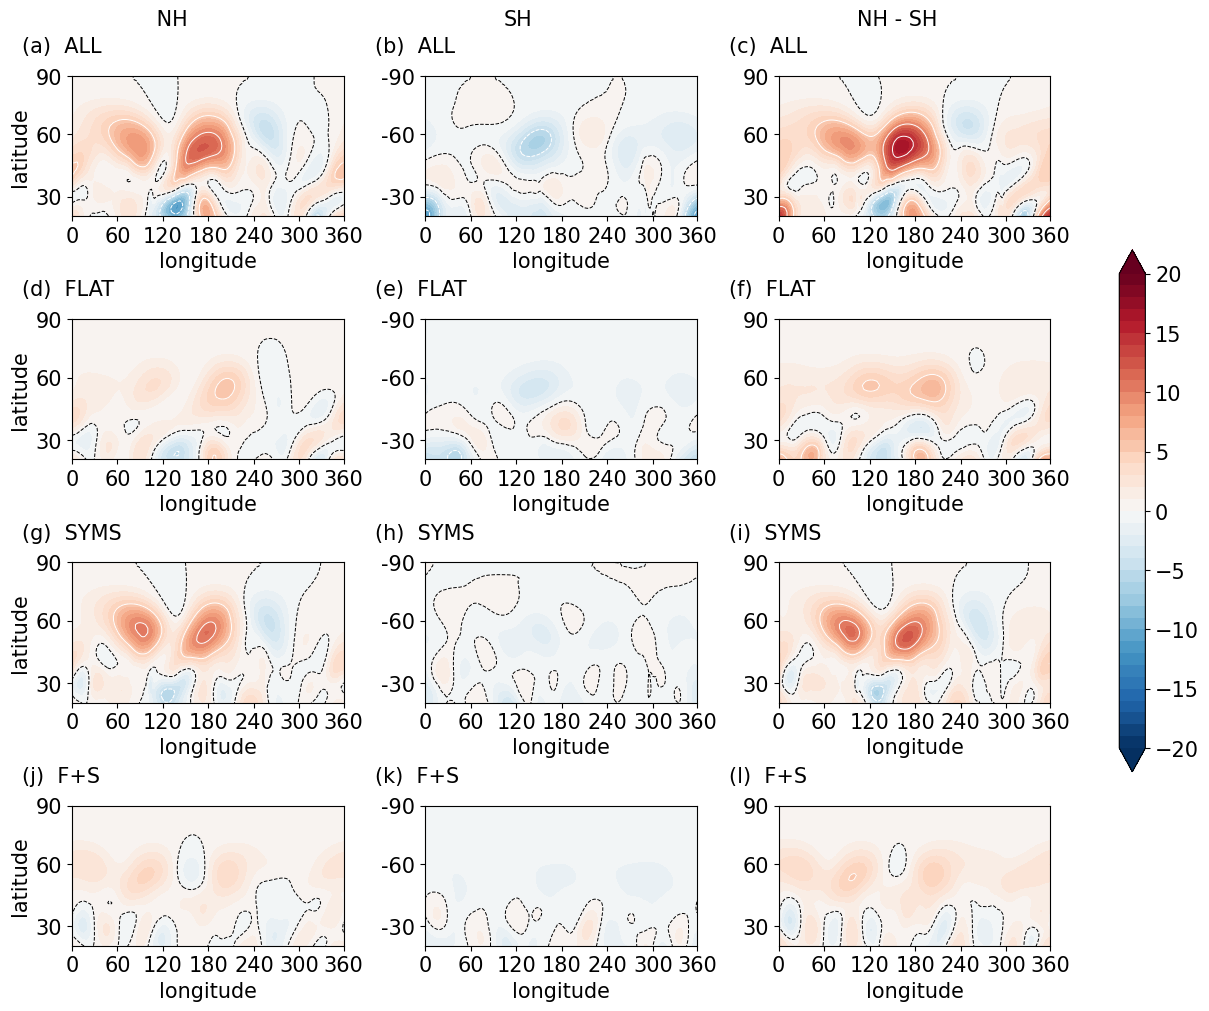

In [68]:
fig,ax = plot.subplots(4,3,figsize=(12,10),constrained_layout=True)#,projection=ccrs.PlateCarree())
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-20,21,1)
cll = np.arange(-20,25,5)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0,0].set_xticks(xxx)
ax[0,0].set_xticklabels(xx)
ax[0,0].set_yticks(yyy)
ax[0,0].set_yticklabels(yy)
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('latitude')
ax[0,0].text(-35,53,'(a)  ALL')
ax[0,0].text(55,60,' NH')
ax[0,0].set_ylim(11,47)


p1=ax[0,0].contourf(x,y,vtre[0,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[0,0].contour(x,y,vtre[0,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p1=ax[0,0].contour(x,y,vtre[0,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_yticks(yyy)
ax[0,1].set_yticklabels(yy)
ax[0,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[0,1].text(-35,53,'(b)  ALL')
ax[0,1].text(55,60,'SH')
ax[0,1].set_ylim(11,47)

p2=ax[0,1].contourf(x,y,vt[0,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[0,1].contour(x,y,vt[0,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[0,1].contour(x,y,vt[0,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_yticks(yyy)
ax[0,2].set_yticklabels(yy)
ax[0,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[0,2].text(-35,53,'(c)  ALL')
ax[0,2].text(55,60,'NH - SH')
ax[0,2].set_ylim(11,47)

p2=ax[0,2].contourf(x,y,-vt[0,48:96,:,12]+vtre[0,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
plot.colorbar(p2,ax=ax.ravel().tolist(),shrink=0.6)
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[0,2].contour(x,y,-vt[0,48:96,:,12]+vtre[0,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[0,2].contour(x,y,-vt[0,48:96,:,12]+vtre[0,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')




ax[1,0].set_xticks(xxx)
ax[1,0].set_xticklabels(xx)
ax[1,0].set_yticks(yyy)
ax[1,0].set_yticklabels(yy)
ax[1,0].set_xlabel('longitude')
ax[1,0].set_ylabel('latitude')
ax[1,0].text(-35,53,'(d)  FLAT')
ax[1,0].set_ylim(11,47)


p1=ax[1,0].contourf(x,y,vtre[1,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[1,0].contour(x,y,vtre[1,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p1=ax[1,0].contour(x,y,vtre[1,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_yticks(yyy)
ax[1,1].set_yticklabels(yy)
ax[1,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[1,1].text(-35,53,'(e)  FLAT')
ax[1,1].set_ylim(11,47)

p2=ax[1,1].contourf(x,y,vt[1,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1,1].contour(x,y,vt[1,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[1,1].contour(x,y,vt[1,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_yticks(yyy)
ax[1,2].set_yticklabels(yy)
ax[1,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[1,2].text(-35,53,'(f)  FLAT')
ax[1,2].set_ylim(11,47)

p2=ax[1,2].contourf(x,y,-vt[1,48:96,:,12]+vtre[1,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1,2].contour(x,y,-vt[1,48:96,:,12]+vtre[1,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[1,2].contour(x,y,-vt[1,48:96,:,12]+vtre[1,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')





ax[2,0].set_xticks(xxx)
ax[2,0].set_xticklabels(xx)
ax[2,0].set_yticks(yyy)
ax[2,0].set_yticklabels(yy)
ax[2,0].set_xlabel('longitude')
ax[2,0].set_ylabel('latitude')
ax[2,0].text(-35,53,'(g)  SYMS')
ax[2,0].set_ylim(11,47)


p1=ax[2,0].contourf(x,y,vtre[2,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[2,0].contour(x,y,vtre[2,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p1=ax[2,0].contour(x,y,vtre[2,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[2,1].set_xticks(xxx)
ax[2,1].set_xticklabels(xx)
ax[2,1].set_yticks(yyy)
ax[2,1].set_yticklabels(yy)
ax[2,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[2,1].text(-35,53,'(h)  SYMS')
ax[2,1].set_ylim(11,47)

p2=ax[2,1].contourf(x,y,vt[2,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[2,1].contour(x,y,vt[2,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[2,1].contour(x,y,vt[2,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[2,2].set_xticks(xxx)
ax[2,2].set_xticklabels(xx)
ax[2,2].set_yticks(yyy)
ax[2,2].set_yticklabels(yy)
ax[2,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[2,2].text(-35,53,'(i)  SYMS')
ax[2,2].set_ylim(11,47)

p2=ax[2,2].contourf(x,y,-vt[2,48:96,:,12]+vtre[2,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[2,2].contour(x,y,-vt[2,48:96,:,12]+vtre[2,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[2,2].contour(x,y,-vt[2,48:96,:,12]+vtre[2,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')





ax[3,0].set_xticks(xxx)
ax[3,0].set_xticklabels(xx)
ax[3,0].set_yticks(yyy)
ax[3,0].set_yticklabels(yy)
ax[3,0].set_xlabel('longitude')
ax[3,0].set_ylabel('latitude')
ax[3,0].text(-35,53,'(j)  F+S')
ax[3,0].set_ylim(11,47)


p1=ax[3,0].contourf(x,y,vtre[3,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[3,0].contour(x,y,vtre[3,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p1=ax[3,0].contour(x,y,vtre[3,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[3,1].set_xticks(xxx)
ax[3,1].set_xticklabels(xx)
ax[3,1].set_yticks(yyy)
ax[3,1].set_yticklabels(yy)
ax[3,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[3,1].text(-35,53,'(k)  F+S')
ax[3,1].set_ylim(11,47)

p2=ax[3,1].contourf(x,y,vt[3,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[3,1].contour(x,y,vt[3,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[3,1].contour(x,y,vt[3,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[3,2].set_xticks(xxx)
ax[3,2].set_xticklabels(xx)
ax[3,2].set_yticks(yyy)
ax[3,2].set_yticklabels(yy)
ax[3,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[3,2].text(-35,53,'(l)  F+S')
ax[3,2].set_ylim(11,47)

p2=ax[3,2].contourf(x,y,-vt[3,48:96,:,12]+vtre[3,48:96,:,12],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[3,2].contour(x,y,-vt[3,48:96,:,12]+vtre[3,48:96,:,12],levels=cll,colors='white',linewidths=0.7)
p2=ax[3,2].contour(x,y,-vt[3,48:96,:,12]+vtre[3,48:96,:,12],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')




plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vt_v_MJ_m^2_ssw_ns_100.png',dpi=600,bbox_inches='tight') 


/tmp/ipykernel_28423/1584054198.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


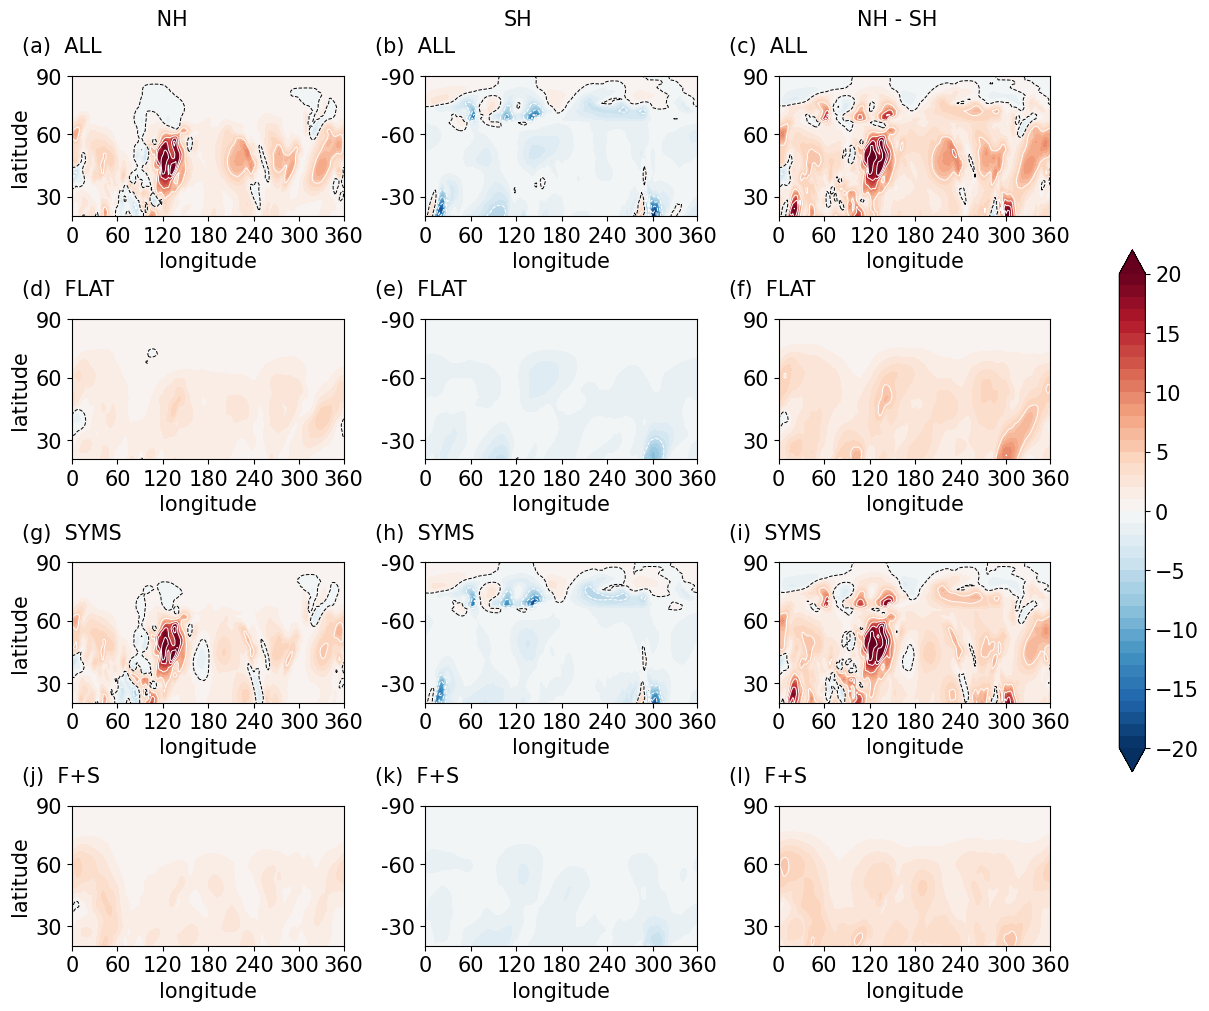

In [69]:
fig,ax = plot.subplots(4,3,figsize=(12,10),constrained_layout=True)#,projection=ccrs.PlateCarree())
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-20,21,1)
cll = np.arange(-20,25,5)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0,0].set_xticks(xxx)
ax[0,0].set_xticklabels(xx)
ax[0,0].set_yticks(yyy)
ax[0,0].set_yticklabels(yy)
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('latitude')
ax[0,0].text(-35,53,'(a)  ALL')
ax[0,0].text(55,60,' NH')
ax[0,0].set_ylim(11,47)


p1=ax[0,0].contourf(x,y,vtre[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[0,0].contour(x,y,vtre[0,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p1=ax[0,0].contour(x,y,vtre[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_yticks(yyy)
ax[0,1].set_yticklabels(yy)
ax[0,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[0,1].text(-35,53,'(b)  ALL')
ax[0,1].text(55,60,'SH')
ax[0,1].set_ylim(11,47)

p2=ax[0,1].contourf(x,y,vt[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[0,1].contour(x,y,vt[0,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[0,1].contour(x,y,vt[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_yticks(yyy)
ax[0,2].set_yticklabels(yy)
ax[0,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[0,2].text(-35,53,'(c)  ALL')
ax[0,2].text(55,60,'NH - SH')
ax[0,2].set_ylim(11,47)

p2=ax[0,2].contourf(x,y,-vt[0,48:96,:,2]+vtre[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
plot.colorbar(p2,ax=ax.ravel().tolist(),shrink=0.6)
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[0,2].contour(x,y,-vt[0,48:96,:,2]+vtre[0,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[0,2].contour(x,y,-vt[0,48:96,:,2]+vtre[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')




ax[1,0].set_xticks(xxx)
ax[1,0].set_xticklabels(xx)
ax[1,0].set_yticks(yyy)
ax[1,0].set_yticklabels(yy)
ax[1,0].set_xlabel('longitude')
ax[1,0].set_ylabel('latitude')
ax[1,0].text(-35,53,'(d)  FLAT')
ax[1,0].set_ylim(11,47)


p1=ax[1,0].contourf(x,y,vtre[1,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[1,0].contour(x,y,vtre[1,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p1=ax[1,0].contour(x,y,vtre[1,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_yticks(yyy)
ax[1,1].set_yticklabels(yy)
ax[1,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[1,1].text(-35,53,'(e)  FLAT')
ax[1,1].set_ylim(11,47)

p2=ax[1,1].contourf(x,y,vt[1,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1,1].contour(x,y,vt[1,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[1,1].contour(x,y,vt[1,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_yticks(yyy)
ax[1,2].set_yticklabels(yy)
ax[1,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[1,2].text(-35,53,'(f)  FLAT')
ax[1,2].set_ylim(11,47)

p2=ax[1,2].contourf(x,y,-vt[1,48:96,:,2]+vtre[1,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1,2].contour(x,y,-vt[1,48:96,:,2]+vtre[1,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[1,2].contour(x,y,-vt[1,48:96,:,2]+vtre[1,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')





ax[2,0].set_xticks(xxx)
ax[2,0].set_xticklabels(xx)
ax[2,0].set_yticks(yyy)
ax[2,0].set_yticklabels(yy)
ax[2,0].set_xlabel('longitude')
ax[2,0].set_ylabel('latitude')
ax[2,0].text(-35,53,'(g)  SYMS')
ax[2,0].set_ylim(11,47)


p1=ax[2,0].contourf(x,y,vtre[2,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[2,0].contour(x,y,vtre[2,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p1=ax[2,0].contour(x,y,vtre[2,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[2,1].set_xticks(xxx)
ax[2,1].set_xticklabels(xx)
ax[2,1].set_yticks(yyy)
ax[2,1].set_yticklabels(yy)
ax[2,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[2,1].text(-35,53,'(h)  SYMS')
ax[2,1].set_ylim(11,47)

p2=ax[2,1].contourf(x,y,vt[2,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[2,1].contour(x,y,vt[2,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[2,1].contour(x,y,vt[2,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[2,2].set_xticks(xxx)
ax[2,2].set_xticklabels(xx)
ax[2,2].set_yticks(yyy)
ax[2,2].set_yticklabels(yy)
ax[2,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[2,2].text(-35,53,'(i)  SYMS')
ax[2,2].set_ylim(11,47)

p2=ax[2,2].contourf(x,y,-vt[2,48:96,:,2]+vtre[2,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[2,2].contour(x,y,-vt[2,48:96,:,2]+vtre[2,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[2,2].contour(x,y,-vt[2,48:96,:,2]+vtre[2,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')





ax[3,0].set_xticks(xxx)
ax[3,0].set_xticklabels(xx)
ax[3,0].set_yticks(yyy)
ax[3,0].set_yticklabels(yy)
ax[3,0].set_xlabel('longitude')
ax[3,0].set_ylabel('latitude')
ax[3,0].text(-35,53,'(j)  F+S')
ax[3,0].set_ylim(11,47)


p1=ax[3,0].contourf(x,y,vtre[3,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[3,0].contour(x,y,vtre[3,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p1=ax[3,0].contour(x,y,vtre[3,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[3,1].set_xticks(xxx)
ax[3,1].set_xticklabels(xx)
ax[3,1].set_yticks(yyy)
ax[3,1].set_yticklabels(yy)
ax[3,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[3,1].text(-35,53,'(k)  F+S')
ax[3,1].set_ylim(11,47)

p2=ax[3,1].contourf(x,y,vt[3,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[3,1].contour(x,y,vt[3,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[3,1].contour(x,y,vt[3,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[3,2].set_xticks(xxx)
ax[3,2].set_xticklabels(xx)
ax[3,2].set_yticks(yyy)
ax[3,2].set_yticklabels(yy)
ax[3,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[3,2].text(-35,53,'(l)  F+S')
ax[3,2].set_ylim(11,47)

p2=ax[3,2].contourf(x,y,-vt[3,48:96,:,2]+vtre[3,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[3,2].contour(x,y,-vt[3,48:96,:,2]+vtre[3,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[3,2].contour(x,y,-vt[3,48:96,:,2]+vtre[3,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')




plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vt_v_MJ_m^2_ssw_ns_850.png',dpi=600,bbox_inches='tight') 


/tmp/ipykernel_28423/3831268509.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


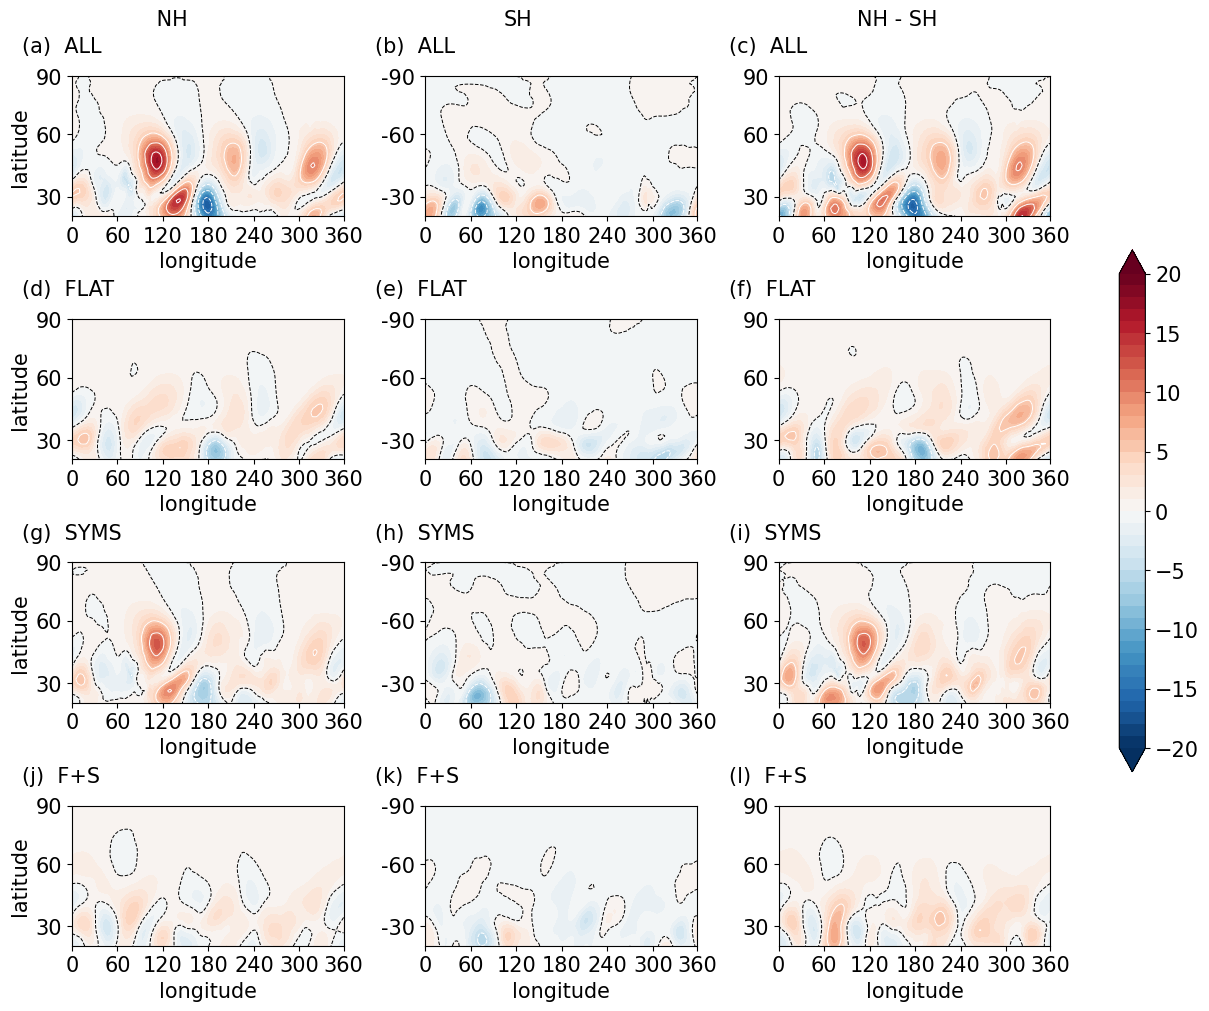

In [70]:
fig,ax = plot.subplots(4,3,figsize=(12,10),constrained_layout=True)#,projection=ccrs.PlateCarree())
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-20,21,1)
cll = np.arange(-20,25,5)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0,0].set_xticks(xxx)
ax[0,0].set_xticklabels(xx)
ax[0,0].set_yticks(yyy)
ax[0,0].set_yticklabels(yy)
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('latitude')
ax[0,0].text(-35,53,'(a)  ALL')
ax[0,0].text(55,60,' NH')
ax[0,0].set_ylim(11,47)


p1=ax[0,0].contourf(x,y,vtre[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[0,0].contour(x,y,vtre[0,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p1=ax[0,0].contour(x,y,vtre[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_yticks(yyy)
ax[0,1].set_yticklabels(yy)
ax[0,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[0,1].text(-35,53,'(b)  ALL')
ax[0,1].text(55,60,'SH')
ax[0,1].set_ylim(11,47)

p2=ax[0,1].contourf(x,y,vt[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[0,1].contour(x,y,vt[0,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[0,1].contour(x,y,vt[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[0,2].set_xticks(xxx)
ax[0,2].set_xticklabels(xx)
ax[0,2].set_yticks(yyy)
ax[0,2].set_yticklabels(yy)
ax[0,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[0,2].text(-35,53,'(c)  ALL')
ax[0,2].text(55,60,'NH - SH')
ax[0,2].set_ylim(11,47)

p2=ax[0,2].contourf(x,y,-vt[0,48:96,:,8]+vtre[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
plot.colorbar(p2,ax=ax.ravel().tolist(),shrink=0.6)
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[0,2].contour(x,y,-vt[0,48:96,:,8]+vtre[0,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[0,2].contour(x,y,-vt[0,48:96,:,8]+vtre[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')




ax[1,0].set_xticks(xxx)
ax[1,0].set_xticklabels(xx)
ax[1,0].set_yticks(yyy)
ax[1,0].set_yticklabels(yy)
ax[1,0].set_xlabel('longitude')
ax[1,0].set_ylabel('latitude')
ax[1,0].text(-35,53,'(d)  FLAT')
ax[1,0].set_ylim(11,47)


p1=ax[1,0].contourf(x,y,vtre[1,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[1,0].contour(x,y,vtre[1,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p1=ax[1,0].contour(x,y,vtre[1,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_yticks(yyy)
ax[1,1].set_yticklabels(yy)
ax[1,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[1,1].text(-35,53,'(e)  FLAT')
ax[1,1].set_ylim(11,47)

p2=ax[1,1].contourf(x,y,vt[1,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1,1].contour(x,y,vt[1,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[1,1].contour(x,y,vt[1,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[1,2].set_xticks(xxx)
ax[1,2].set_xticklabels(xx)
ax[1,2].set_yticks(yyy)
ax[1,2].set_yticklabels(yy)
ax[1,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[1,2].text(-35,53,'(f)  FLAT')
ax[1,2].set_ylim(11,47)

p2=ax[1,2].contourf(x,y,-vt[1,48:96,:,8]+vtre[1,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1,2].contour(x,y,-vt[1,48:96,:,8]+vtre[1,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[1,2].contour(x,y,-vt[1,48:96,:,8]+vtre[1,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')





ax[2,0].set_xticks(xxx)
ax[2,0].set_xticklabels(xx)
ax[2,0].set_yticks(yyy)
ax[2,0].set_yticklabels(yy)
ax[2,0].set_xlabel('longitude')
ax[2,0].set_ylabel('latitude')
ax[2,0].text(-35,53,'(g)  SYMS')
ax[2,0].set_ylim(11,47)


p1=ax[2,0].contourf(x,y,vtre[2,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[2,0].contour(x,y,vtre[2,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p1=ax[2,0].contour(x,y,vtre[2,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[2,1].set_xticks(xxx)
ax[2,1].set_xticklabels(xx)
ax[2,1].set_yticks(yyy)
ax[2,1].set_yticklabels(yy)
ax[2,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[2,1].text(-35,53,'(h)  SYMS')
ax[2,1].set_ylim(11,47)

p2=ax[2,1].contourf(x,y,vt[2,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[2,1].contour(x,y,vt[2,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[2,1].contour(x,y,vt[2,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[2,2].set_xticks(xxx)
ax[2,2].set_xticklabels(xx)
ax[2,2].set_yticks(yyy)
ax[2,2].set_yticklabels(yy)
ax[2,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[2,2].text(-35,53,'(i)  SYMS')
ax[2,2].set_ylim(11,47)

p2=ax[2,2].contourf(x,y,-vt[2,48:96,:,8]+vtre[2,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[2,2].contour(x,y,-vt[2,48:96,:,8]+vtre[2,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[2,2].contour(x,y,-vt[2,48:96,:,8]+vtre[2,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')





ax[3,0].set_xticks(xxx)
ax[3,0].set_xticklabels(xx)
ax[3,0].set_yticks(yyy)
ax[3,0].set_yticklabels(yy)
ax[3,0].set_xlabel('longitude')
ax[3,0].set_ylabel('latitude')
ax[3,0].text(-35,53,'(j)  F+S')
ax[3,0].set_ylim(11,47)


p1=ax[3,0].contourf(x,y,vtre[3,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[3,0].contour(x,y,vtre[3,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p1=ax[3,0].contour(x,y,vtre[3,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[3,1].set_xticks(xxx)
ax[3,1].set_xticklabels(xx)
ax[3,1].set_yticks(yyy)
ax[3,1].set_yticklabels(yy)
ax[3,1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[3,1].text(-35,53,'(k)  F+S')
ax[3,1].set_ylim(11,47)

p2=ax[3,1].contourf(x,y,vt[3,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[3,1].contour(x,y,vt[3,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[3,1].contour(x,y,vt[3,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[3,2].set_xticks(xxx)
ax[3,2].set_xticklabels(xx)
ax[3,2].set_yticks(yyy)
ax[3,2].set_yticklabels(yy)
ax[3,2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[3,2].text(-35,53,'(l)  F+S')
ax[3,2].set_ylim(11,47)

p2=ax[3,2].contourf(x,y,-vt[3,48:96,:,8]+vtre[3,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[3,2].contour(x,y,-vt[3,48:96,:,8]+vtre[3,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[3,2].contour(x,y,-vt[3,48:96,:,8]+vtre[3,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')




plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vt_v_MJ_m^2_ssw_ns_300.png',dpi=600,bbox_inches='tight') 


In [210]:
np.mean(np.mean(-tpl[3,59:96,0:191]+tplre[3,59:96,0:191],axis=0),axis=0)

-0.08634156695165329

In [214]:
np.mean(np.mean((tplre[0,59:96,0:191]),axis=0),axis=0)

-0.12383257156224198

/tmp/ipykernel_52847/4122139729.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


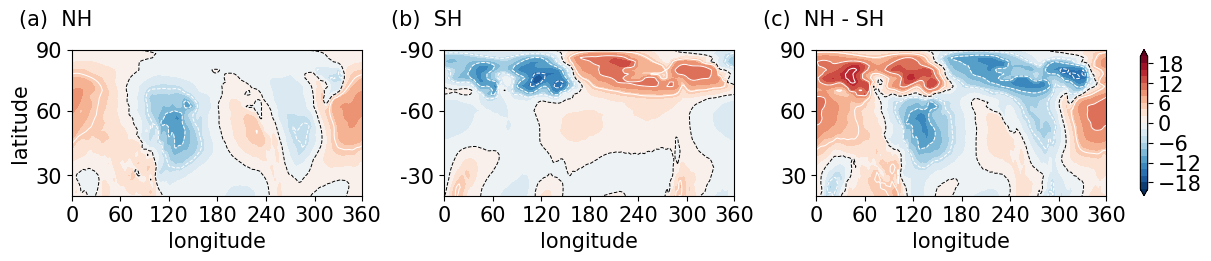

In [38]:
fig,ax = plot.subplots(1,3,figsize=(12,2.5),constrained_layout=True)#,projection=ccrs.PlateCarree())
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-20,22,2)
cll = np.arange(-20,25,5)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0].set_xticks(xxx)
ax[0].set_xticklabels(xx)
ax[0].set_yticks(yyy)
ax[0].set_yticklabels(yy)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].text(-35,53,'(a)  NH')
ax[0].set_ylim(11,47)



p1=ax[0].contourf(x,y,tplre[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,tplre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[0].contour(x,y,tplre[0,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p1=ax[0].contour(x,y,tplre[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[1].set_xticks(xxx)
ax[1].set_xticklabels(xx)
ax[1].set_yticks(yyy)
ax[1].set_yticklabels(yy)
ax[1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[1].text(-35,53,'(b)  SH')
ax[1].set_ylim(11,47)

p2=ax[1].contourf(x,y,tpl[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1].contour(x,y,tpl[0,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[1].contour(x,y,tpl[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[2].set_xticks(xxx)
ax[2].set_xticklabels(xx)
ax[2].set_yticks(yyy)
ax[2].set_yticklabels(yy)
ax[2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[2].text(-35,53,'(c)  NH - SH')
ax[2].set_ylim(11,47)

p2=ax[2].contourf(x,y,-tpl[0,48:96,:,2]+tplre[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p2=ax[2].contour(x,y,-tpl[0,48:96,:,2]+tplre[0,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[2].contour(x,y,-tpl[0,48:96,:,2]+tplre[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/tpl_v_MJ_m^2_ssw_ns_850.png',dpi=600,bbox_inches='tight') 


/tmp/ipykernel_52847/3374655683.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


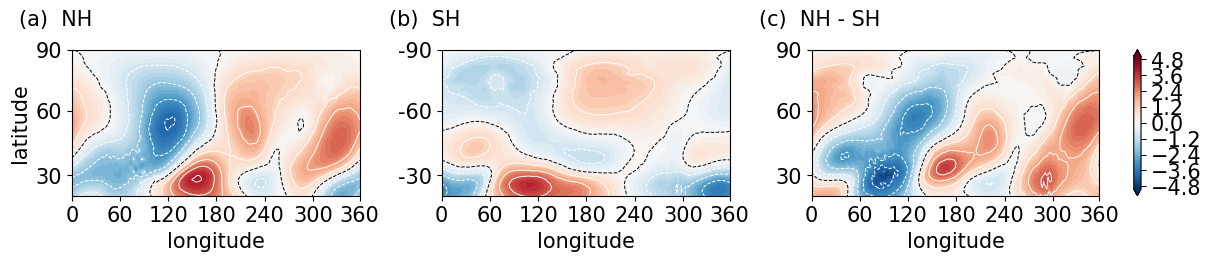

In [40]:
fig,ax = plot.subplots(1,3,figsize=(12,2.5),constrained_layout=True)#,projection=ccrs.PlateCarree())
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-5,5.2,0.2)
cll = np.arange(-5,6,1)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0].set_xticks(xxx)
ax[0].set_xticklabels(xx)
ax[0].set_yticks(yyy)
ax[0].set_yticklabels(yy)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].text(-35,53,'(a)  NH')
ax[0].set_ylim(11,47)



p1=ax[0].contourf(x,y,tplre[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,tplre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[0].contour(x,y,tplre[0,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p1=ax[0].contour(x,y,tplre[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[1].set_xticks(xxx)
ax[1].set_xticklabels(xx)
ax[1].set_yticks(yyy)
ax[1].set_yticklabels(yy)
ax[1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[1].text(-35,53,'(b)  SH')
ax[1].set_ylim(11,47)

p2=ax[1].contourf(x,y,tpl[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1].contour(x,y,tpl[0,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[1].contour(x,y,tpl[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[2].set_xticks(xxx)
ax[2].set_xticklabels(xx)
ax[2].set_yticks(yyy)
ax[2].set_yticklabels(yy)
ax[2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[2].text(-35,53,'(c)  NH - SH')
ax[2].set_ylim(11,47)

p2=ax[2].contourf(x,y,-tpl[0,48:96,:,8]+tplre[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p2=ax[2].contour(x,y,-tpl[0,48:96,:,8]+tplre[0,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[2].contour(x,y,-tpl[0,48:96,:,8]+tplre[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/tpl_v_MJ_m^2_ssw_ns_300.png',dpi=600,bbox_inches='tight') 


/tmp/ipykernel_52847/329940516.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


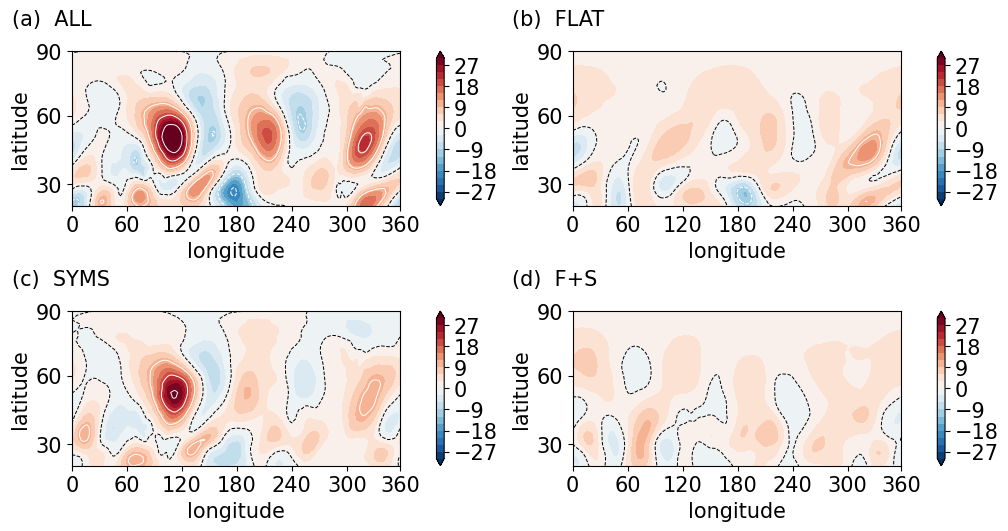

In [46]:
fig,ax = plot.subplots(2,2,figsize=(10,5.2),constrained_layout=True)
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-30,33,3)
cl1 = np.arange(-30,40,10)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0,0].set_xticks(xxx)
ax[0,0].set_xticklabels(xx)
ax[0,0].set_yticks(yyy)
ax[0,0].set_yticklabels(yy)
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('latitude')
ax[0,0].text(-35,53,'(a)  ALL')
ax[0,0].set_ylim(11,47)

p1=ax[0,0].contourf(x,y,-vt[0,48:96,:,8]+vtre[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p1,ax=ax[0,0])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p1=ax[0,0].contour(x,y,-vt[0,48:96,:,8]+vtre[0,48:96,:,8],levels=cl1,colors='white',linewidths=0.7)
p1=ax[0,0].contour(x,y,-vt[0,48:96,:,8]+vtre[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')



ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_yticks(yyy)
ax[0,1].set_yticklabels(yy)
ax[0,1].set_xlabel('longitude')
ax[0,1].set_ylabel('latitude')
ax[0,1].text(-35,53,'(b)  FLAT')
ax[0,1].set_ylim(11,47)

p2=ax[0,1].contourf(x,y,-vt[1,48:96,:,8]+vtre[1,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p2,ax=ax[0,1])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p2=ax[0,1].contour(x,y,-vt[1,48:96,:,8]+vtre[1,48:96,:,8],levels=cl1,colors='white',linewidths=0.7)
p2=ax[0,1].contour(x,y,-vt[1,48:96,:,8]+vtre[1,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')



ax[1,0].set_xticks(xxx)
ax[1,0].set_xticklabels(xx)
ax[1,0].set_yticks(yyy)
ax[1,0].set_yticklabels(yy)
ax[1,0].set_xlabel('longitude')
ax[1,0].set_ylabel('latitude')
ax[1,0].text(-35,53,'(c)  SYMS')
ax[1,0].set_ylim(11,47)

p3=ax[1,0].contourf(x,y,-vt[2,48:96,:,8]+vtre[2,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p3,ax=ax[1,0])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p3=ax[1,0].contour(x,y,-vt[2,48:96,:,8]+vtre[2,48:96,:,8],levels=cl1,colors='white',linewidths=0.7)
p3=ax[1,0].contour(x,y,-vt[2,48:96,:,8]+vtre[2,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')



ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_yticks(yyy)
ax[1,1].set_yticklabels(yy)
ax[1,1].set_xlabel('longitude')
ax[1,1].set_ylabel('latitude')
ax[1,1].text(-35,53,'(d)  F+S')
ax[1,1].set_ylim(11,47)

p4=ax[1,1].contourf(x,y,-vt[3,48:96,:,8]+vtre[3,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p4,ax=ax[1,1])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p4=ax[1,1].contour(x,y,-vt[3,48:96,:,8]+vtre[3,48:96,:,8],levels=cl1,colors='white',linewidths=0.7)
p4=ax[1,1].contour(x,y,-vt[3,48:96,:,8]+vtre[3,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


barplot=np.zeros((4))
barplot[0] = (-np.mean(np.mean(vt[0,59:96,0:191,8],axis=0),axis=0)+np.mean(np.mean((vtre[0,59:96,0:191,8]),axis=0),axis=0))/np.mean(np.mean((vtre[0,59:96,0:191,8]),axis=0),axis=0)*100
barplot[1] = (-np.mean(np.mean(vt[1,59:96,0:191,8],axis=0),axis=0)+np.mean(np.mean((vtre[1,59:96,0:191,8]),axis=0),axis=0))/np.mean(np.mean((vtre[1,59:96,0:191,8]),axis=0),axis=0)*100
barplot[2] = (-np.mean(np.mean(vt[2,59:96,0:191,8],axis=0),axis=0)+np.mean(np.mean((vtre[2,59:96,0:191,8]),axis=0),axis=0))/np.mean(np.mean((vtre[2,59:96,0:191,8]),axis=0),axis=0)*100
barplot[3] = (-np.mean(np.mean(vt[3,59:96,0:191,8],axis=0),axis=0)+np.mean(np.mean((vtre[3,59:96,0:191,8]),axis=0),axis=0))/np.mean(np.mean((vtre[3,59:96,0:191,8]),axis=0),axis=0)*100



# name_list = ['ALL','FLAT','SYMS','F+S']
# ax[2,0].bar(range(len(barplot)),barplot,tick_label = name_list)
# ax[2,0].set_xlim(-1,4)
# ax[2,0].set_ylim(-80,80)
# ax[2,0].set_yticks([-20,-10,0,10,20,30,40])
# ax[2,0].set_yticklabels([-20,-10,0,10,20,30,40])
# ax[2,0].set_ylabel('Percent') 
# ax[2,0].text(-1.9,45,'(e)')
# ax[2,0].axhline(y=0,color='black',linewidth='1')

# ax[2,1].axis('off')

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vt_v_MJ_m^2_ssw_300.png',dpi=600,bbox_inches='tight') 



/tmp/ipykernel_52847/1655398053.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


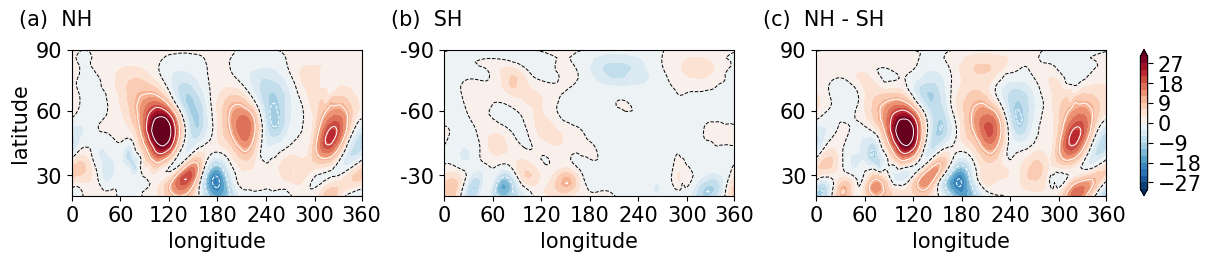

In [51]:
fig,ax = plot.subplots(1,3,figsize=(12,2.5),constrained_layout=True)#,projection=ccrs.PlateCarree())
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-30,33,3)
cll = np.arange(-30,40,10)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0].set_xticks(xxx)
ax[0].set_xticklabels(xx)
ax[0].set_yticks(yyy)
ax[0].set_yticklabels(yy)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].text(-35,53,'(a)  NH')
ax[0].set_ylim(11,47)



p1=ax[0].contourf(x,y,vtre[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[0].contour(x,y,vtre[0,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p1=ax[0].contour(x,y,vtre[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[1].set_xticks(xxx)
ax[1].set_xticklabels(xx)
ax[1].set_yticks(yyy)
ax[1].set_yticklabels(yy)
ax[1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[1].text(-35,53,'(b)  SH')
ax[1].set_ylim(11,47)

p2=ax[1].contourf(x,y,vt[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1].contour(x,y,vt[0,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[1].contour(x,y,vt[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[2].set_xticks(xxx)
ax[2].set_xticklabels(xx)
ax[2].set_yticks(yyy)
ax[2].set_yticklabels(yy)
ax[2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[2].text(-35,53,'(c)  NH - SH')
ax[2].set_ylim(11,47)

p2=ax[2].contourf(x,y,-vt[0,48:96,:,8]+vtre[0,48:96,:,8],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p2=ax[2].contour(x,y,-vt[0,48:96,:,8]+vtre[0,48:96,:,8],levels=cll,colors='white',linewidths=0.7)
p2=ax[2].contour(x,y,-vt[0,48:96,:,8]+vtre[0,48:96,:,8],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vt_v_MJ_m^2_ssw_ns_300.png',dpi=600,bbox_inches='tight') 


/tmp/ipykernel_52847/4055368371.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


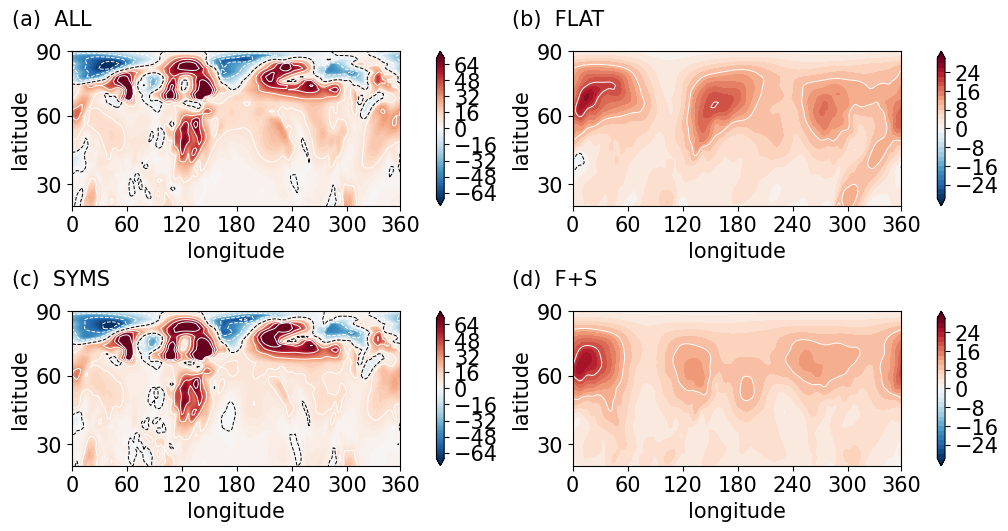

In [57]:
fig,ax = plot.subplots(2,2,figsize=(10,5.2),constrained_layout=True)
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-70,72,2)
cl1 = np.arange(-70,75,20)

cl2 = np.arange(-30,32,2)
cl12 = np.arange(-30,35,10)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0,0].set_xticks(xxx)
ax[0,0].set_xticklabels(xx)
ax[0,0].set_yticks(yyy)
ax[0,0].set_yticklabels(yy)
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('latitude')
ax[0,0].text(-35,53,'(a)  ALL')
ax[0,0].set_ylim(11,47)

p1=ax[0,0].contourf(x,y,-vt[0,48:96,:,2]+vtre[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p1,ax=ax[0,0])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p1=ax[0,0].contour(x,y,-vt[0,48:96,:,2]+vtre[0,48:96,:,2],levels=cl1,colors='white',linewidths=0.7)
p1=ax[0,0].contour(x,y,-vt[0,48:96,:,2]+vtre[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')



ax[0,1].set_xticks(xxx)
ax[0,1].set_xticklabels(xx)
ax[0,1].set_yticks(yyy)
ax[0,1].set_yticklabels(yy)
ax[0,1].set_xlabel('longitude')
ax[0,1].set_ylabel('latitude')
ax[0,1].text(-35,53,'(b)  FLAT')
ax[0,1].set_ylim(11,47)

p2=ax[0,1].contourf(x,y,-vt[1,48:96,:,2]+vtre[1,48:96,:,2],cmap=reversed_map,levels=cl2,extend='both')
cbar=plot.colorbar(p2,ax=ax[0,1])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p2=ax[0,1].contour(x,y,-vt[1,48:96,:,2]+vtre[1,48:96,:,2],levels=cl12,colors='white',linewidths=0.7)
p2=ax[0,1].contour(x,y,-vt[1,48:96,:,2]+vtre[1,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')



ax[1,0].set_xticks(xxx)
ax[1,0].set_xticklabels(xx)
ax[1,0].set_yticks(yyy)
ax[1,0].set_yticklabels(yy)
ax[1,0].set_xlabel('longitude')
ax[1,0].set_ylabel('latitude')
ax[1,0].text(-35,53,'(c)  SYMS')
ax[1,0].set_ylim(11,47)

p3=ax[1,0].contourf(x,y,-vt[2,48:96,:,2]+vtre[2,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p3,ax=ax[1,0])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p3=ax[1,0].contour(x,y,-vt[2,48:96,:,2]+vtre[2,48:96,:,2],levels=cl1,colors='white',linewidths=0.7)
p3=ax[1,0].contour(x,y,-vt[2,48:96,:,2]+vtre[2,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')



ax[1,1].set_xticks(xxx)
ax[1,1].set_xticklabels(xx)
ax[1,1].set_yticks(yyy)
ax[1,1].set_yticklabels(yy)
ax[1,1].set_xlabel('longitude')
ax[1,1].set_ylabel('latitude')
ax[1,1].text(-35,53,'(d)  F+S')
ax[1,1].set_ylim(11,47)

p4=ax[1,1].contourf(x,y,-vt[3,48:96,:,2]+vtre[3,48:96,:,2],cmap=reversed_map,levels=cl2,extend='both')
cbar=plot.colorbar(p4,ax=ax[1,1])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p4=ax[1,1].contour(x,y,-vt[3,48:96,:,2]+vtre[3,48:96,:,2],levels=cl12,colors='white',linewidths=0.7)
p4=ax[1,1].contour(x,y,-vt[3,48:96,:,2]+vtre[3,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


barplot=np.zeros((4))
barplot[0] = (-np.mean(np.mean(vt[0,59:96,0:191,2],axis=0),axis=0)+np.mean(np.mean((vtre[0,59:96,0:191,2]),axis=0),axis=0))/np.mean(np.mean((vtre[0,59:96,0:191,2]),axis=0),axis=0)*100
barplot[1] = (-np.mean(np.mean(vt[1,59:96,0:191,2],axis=0),axis=0)+np.mean(np.mean((vtre[1,59:96,0:191,2]),axis=0),axis=0))/np.mean(np.mean((vtre[1,59:96,0:191,2]),axis=0),axis=0)*100
barplot[2] = (-np.mean(np.mean(vt[2,59:96,0:191,2],axis=0),axis=0)+np.mean(np.mean((vtre[2,59:96,0:191,2]),axis=0),axis=0))/np.mean(np.mean((vtre[2,59:96,0:191,2]),axis=0),axis=0)*100
barplot[3] = (-np.mean(np.mean(vt[3,59:96,0:191,2],axis=0),axis=0)+np.mean(np.mean((vtre[3,59:96,0:191,2]),axis=0),axis=0))/np.mean(np.mean((vtre[3,59:96,0:191,2]),axis=0),axis=0)*100



# name_list = ['ALL','FLAT','SYMS','F+S']
# ax[2,0].bar(range(len(barplot)),barplot,tick_label = name_list)
# ax[2,0].set_xlim(-1,4)
# ax[2,0].set_ylim(-80,80)
# ax[2,0].set_yticks([-20,-10,0,10,20,30,40])
# ax[2,0].set_yticklabels([-20,-10,0,10,20,30,40])
# ax[2,0].set_ylabel('Percent') 
# ax[2,0].text(-1.9,45,'(e)')
# ax[2,0].axhline(y=0,color='black',linewidth='1')

# ax[2,1].axis('off')

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vt_v_MJ_m^2_ssw_850.png',dpi=600,bbox_inches='tight') 




/tmp/ipykernel_52847/2327212175.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plot.cm.get_cmap('RdBu')


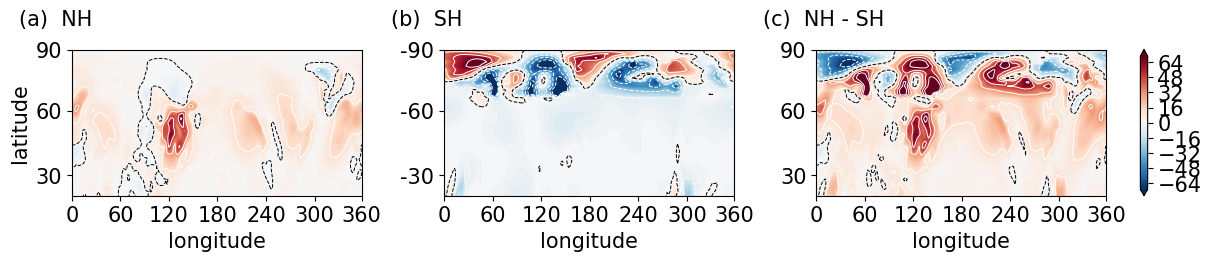

In [58]:
fig,ax = plot.subplots(1,3,figsize=(12,2.5),constrained_layout=True)#,projection=ccrs.PlateCarree())
plot.rcParams['font.size'] = '15'

x = np.arange(0,192,1)
y = np.arange(0,48,1)

orig_map=plot.cm.get_cmap('RdBu')
reversed_map = orig_map.reversed()

cl = np.arange(-70,72,2)
cll = np.arange(-70,75,20)

xx = [0,60,120,180,240,300,360]
xxx = [0,32,64,96,128,160,191]
yy = [0,30,60,90]
yyy = [0,16,32,47]

ax[0].set_xticks(xxx)
ax[0].set_xticklabels(xx)
ax[0].set_yticks(yyy)
ax[0].set_yticklabels(yy)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].text(-35,53,'(a)  NH')
ax[0].set_ylim(11,47)



p1=ax[0].contourf(x,y,vtre[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#p1=ax[0].contourf(x,y,vtre[0,48:96,:],cmap=reversed_map)
#cbar=plot.colorbar(p1,ax=ax[0],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p1=ax[0].contour(x,y,vtre[0,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p1=ax[0].contour(x,y,vtre[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')


yy = [0,-30,-60,-90]

ax[1].set_xticks(xxx)
ax[1].set_xticklabels(xx)
ax[1].set_yticks(yyy)
ax[1].set_yticklabels(yy)
ax[1].set_xlabel('longitude')
#ax[1].set_ylabel('latitude')
ax[1].text(-35,53,'(b)  SH')
ax[1].set_ylim(11,47)

p2=ax[1].contourf(x,y,vt[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
#cbar=plot.colorbar(p2,ax=ax[1],ticks=[-1e6,0,1e6])
#cbar.ax.set_yticklabels(['-1e6', '0', '1e6']) 
p2=ax[1].contour(x,y,vt[0,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[1].contour(x,y,vt[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

yy = [0,30,60,90]

ax[2].set_xticks(xxx)
ax[2].set_xticklabels(xx)
ax[2].set_yticks(yyy)
ax[2].set_yticklabels(yy)
ax[2].set_xlabel('longitude')
#ax[2].set_ylabel('latitude')
ax[2].text(-35,53,'(c)  NH - SH')
ax[2].set_ylim(11,47)

p2=ax[2].contourf(x,y,-vt[0,48:96,:,2]+vtre[0,48:96,:,2],cmap=reversed_map,levels=cl,extend='both')
cbar=plot.colorbar(p2,ax=ax[2])#,ticks=[-60,-30,0,30,60])
#cbar.ax.set_yticklabels(['-60','-30', '0','30', '60']) 
p2=ax[2].contour(x,y,-vt[0,48:96,:,2]+vtre[0,48:96,:,2],levels=cll,colors='white',linewidths=0.7)
p2=ax[2].contour(x,y,-vt[0,48:96,:,2]+vtre[0,48:96,:,2],levels=[0],colors='black',linewidths=0.7,linestyles='dashed')

plot.savefig('/home/smliu01/scratch-midway2/ssw/plot/vt_v_MJ_m^2_ssw_ns_850.png',dpi=600,bbox_inches='tight') 
